In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from tqdm import tqdm
from pandarallel import pandarallel
import os

In [2]:
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [3]:
# Setting working directory
import json
with open('setup.json', 'r') as openfile:
    setup_object = json.load(openfile)
    WD = setup_object["wd_path"]

In [4]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']

In [5]:
days = ['MON', 'TUE', 'WED', 'THU', 'FRI']

In [6]:
# Load the dataset

dfs = []
for day in days:
    dfs.append(pd.read_parquet(f'{WD}/preprocessed/{day}v2.parquet'))

In [7]:
dfs[0].columns

Index(['id', 'bidirectional_duration_ms', 'application_name',
       'application_category_name', 'location', 'connection_type',
       'start_second', 'start_time_aggr',
       'bidirectional_first_seen_relative_ms',
       'bidirectional_last_seen_relative_ms', 'bidirectional_packets',
       'LAN_delay', 'LAN_delay_timestamps', 'LAN_delay_neighboring_PS',
       'LAN_jitter'],
      dtype='object')

In [8]:
for df in tqdm(dfs):
    df['LAN_time'] = df.apply(lambda row: row['LAN_delay_timestamps'][-1] + row['LAN_delay'][-1] - row['LAN_delay_timestamps'][0], axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:54<00:00, 58.80s/it]


In [9]:
def legend_without_duplicate_labels(ax, *args, **kwargs):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), *args, **kwargs)

---

We are going to use *Location 2* for in depth SD analyis. Only the chosen method will be to the other two locations.

In [10]:
df_l2s = []
for df in tqdm(dfs):
    df_l2 = df[df['location'].str.startswith('2')]
    df_l2s.append(df_l2)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.45s/it]


In [11]:
df_train = df_l2s[:3]
df_train_all = pd.concat(df_train).reset_index(drop=True)

# Cardinality Analysis

In this notebook we explore Service Degradation events in the data. We define Service Degradation (SD) as a statistically significant deviation from the normal flow latency behavior, i.e. a significant increase in latency and jitter of a flow. The threshold used for this classification may be application category dependent, as even minimal latency differences can be considered service degradation for delay-sensitive applications, such as voice calls or remote access. In contrast, an increase in latency during download is not that noticeable, as these are not sensitive from a latency perspective. This warrants an application category-dependent threshold. By considering the unique characteristics of each application category, this approach can provide a more accurate representation of what constitutes SD for that specific category.

Another dimension we study is prolonged Service Degradation events, i.e. when the deviation in latency and jitter is present for longer consecutive portion of time. For this we define a SD event as a contiguous list of delays where the the corresponding jitter to the first delay is an outlier and the following delays are outliers themselves. In essence we are looking for sequences where delay grows unexpectedly and stays above the threshold set for anomalies.

We also examine cases when while the delays experience significantly higher distribution, the traffic remains jittery throughout this period, i.e. the jitter also stays beyond the SD threshold.

Some application categories might have limited data points, leading to potential overfitting or unreliable threshold estimations. Therefore, it is imperative to analyze the cardinality of each application category and the number of available delay (and jitter) samples. We perform these in the next steps

### Application Cardinality

<font color='gray'>*We analyzed this metric in the previous notebook. It appears here reiterated for better analyzability.*</font>

In [12]:
# Check the cardinality of the application categories
category_name_counts = df_train_all['application_category_name'].value_counts()
category_name_counts

application_category_name
Web               1001308
SocialNetwork      202542
Cloud              169891
Download           109179
Network             76601
Collaborative       73506
Advertisement       44850
Game                37782
Chat                32542
Music               23104
Media               23071
Video               19839
SoftwareUpdate      19573
Cybersecurity       15904
Streaming           13191
ConnCheck           11849
VoIP                10505
System               9776
Email                8583
Database             2857
VPN                  1837
VirtAssistant        1590
DataTransfer         1021
RemoteAccess          334
RPC                   277
Mining                 50
Shopping               37
IoT-Scada              13
Name: count, dtype: int64

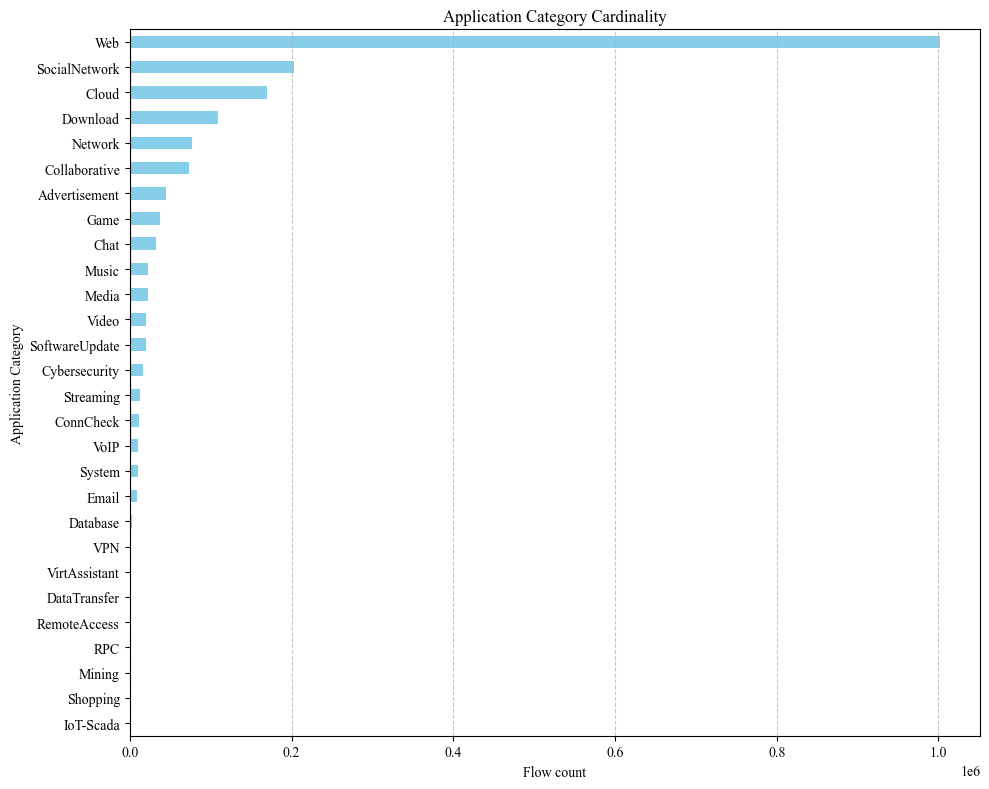

In [13]:
# Visualize the total number of LAN delays for each application category
plt.figure(figsize=(10, 8))
category_name_counts.plot(kind='barh', color='skyblue')
plt.xlabel('Flow count')
plt.ylabel('Application Category')
plt.gca().invert_yaxis()  # Invert y-axis to have categories with the highest counts at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/SDanalysis/trainset_app_cat_cardinality.pdf')
plt.title('Application Category Cardinality')
plt.tight_layout()
plt.show()

Let's filter the dataset to only those application categories that have at least 50,000 flows in the training set. This results in the following top 6 selection: *Web*, *SocialNetwork*, *Cloud*, *Download*, *Network* and *Collaborative*.

In [14]:
df_l2s_filtereds = []
for df in tqdm(df_l2s):
    df_l2s_filtereds.append(df[df['application_category_name'].isin(['Web', 'SocialNetwork', 'Download', 'Cloud', 'Network', 'Collaborative'])])

df_train = df_l2s_filtereds[:3]
df_train_all = pd.concat(df_train).reset_index(drop=True)
df_train_all.index.name = 'index'

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.67it/s]


### Count of available LAN delays per application category

In [15]:
# Calculate the total number of LAN delays for each application category
total_delays_per_category = df_train_all.groupby('application_category_name').apply(lambda x: x['LAN_delay'].apply(len).sum())

# Sort the results in descending order
total_delays_per_category = total_delays_per_category.sort_values(ascending=False)
total_delays_per_category

application_category_name
Web              9016470
SocialNetwork    1797216
Cloud            1177916
Collaborative     743453
Download          440421
Network           264156
dtype: int64

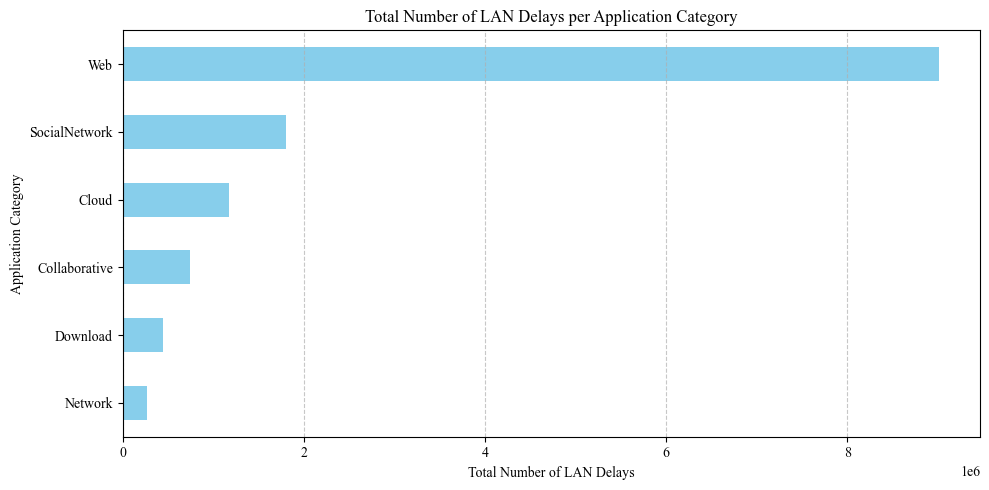

In [16]:
# Visualize the total number of LAN delays for each application category
plt.figure(figsize=(10, 5))
total_delays_per_category.plot(kind='barh', color='skyblue')
plt.xlabel('Total Number of LAN Delays')
plt.ylabel('Application Category')
plt.gca().invert_yaxis()  # Invert y-axis to have categories with the highest counts at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/SDanalysis/delay_trainset_app_cat_cardinality.pdf')
plt.title('Total Number of LAN Delays per Application Category')
plt.tight_layout()
plt.show()

<!-- The results are in line with our previous observation with a similar resulting distribution. With the least populous *Download* category having almost 100,000 delay samples all of the categories have enough samples to define an empirical distribution. -->

# Quartile Analysis (IQR Analysis)

To examine the distribution of the delays in each category we plot the corresponding distribution for each category on boxplots. The y-axis is set to a logarithmic scale in order to better articulate the differences. The order of bloxplots is the according to the number of delay samples in descending order as seen in the previous plot. The means are also marked on the plots with orange rectangles.

In [17]:
# Explode the 'LAN_delay' and 'LAN_jitter' columns to create a row for each delay
df_exploded_delay = df_train_all[['application_category_name', 'LAN_delay']].explode('LAN_delay').reset_index()
df_exploded_jitter = df_train_all[['application_category_name', 'LAN_jitter']].explode('LAN_jitter').reset_index()
# Uniting the two metrics into a single DataFrame
df_exploded_delay.columns = df_exploded_delay.columns.to_list()[:-1] + ["Delay / Jitter [ms]"]
df_exploded_delay['Metric'] = "Delay"
df_exploded_jitter.columns = df_exploded_jitter.columns.to_list()[:-1] + ["Delay / Jitter [ms]"]
df_exploded_jitter['Metric'] = "Jitter"
df_exploded = pd.concat([df_exploded_delay, df_exploded_jitter])

C:\Users\Dev\AppData\Local\Temp\ipykernel_11772\280357952.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


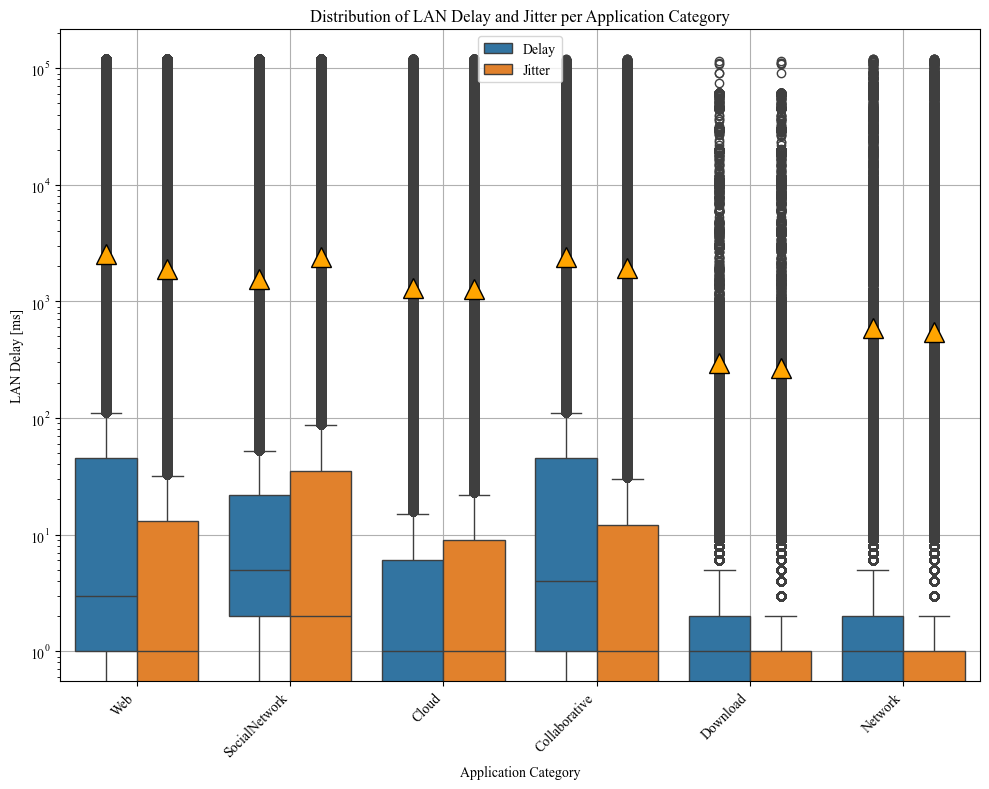

In [18]:
# Visualize the distribution of metircs for each category using boxplots
plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='application_category_name',
                 y='Delay / Jitter [ms]',
                 hue='Metric',
                 data=df_exploded,
                 order=total_delays_per_category.index,
                 showmeans=True,
                 meanprops={"marker":"^",
                            "markerfacecolor":"orange", 
                            "markeredgecolor":"black",
                            "markersize":"15"})
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel('LAN Delay [ms]')
plt.xlabel('Application Category')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('plots/SDanalysis/app_cat_delay_distribution.pdf')
plt.title('Distribution of LAN Delay and Jitter per Application Category')
plt.tight_layout()
plt.show()

**Delay**

We see that the different application categories have distinct distributions, although 2 characteristically different groups are distinguishable. The majority *Download* and *Network* type delays don't reach 10 ms while the other groups go up into tens on milliseconds surpassing 100 ms by their upper whisker. *Cloud*, *Download* and *Network* also have delays in the sub-millisecond range with a median at 1 ms. NFStream cannot measure at this granularity, therefore sub-one-ms delay were reported as 0 milliseconds. The mean values also follow the trend of lower average delay for *Download* and *Network* below 1 second, while the other categories have their means at a few seconds. The high mean compared to median is due to a strong presence of outliers identified by the IQR analysis.

**Jitter**

The jitter distribution follows similar patterns as the delay distribution for all application categories. All categories have a lower or equal median jitter than median delay, with the first quartile reaching 0 ms (indicating a significant presence of no jitter, i.e. constant delays). *Social Network* flows on the other hand have a few milliseconds longer jitter than delay in terms of their third quartile, whisker and mean.

---

Outliers beyond the whiskers are observed in all categories. These range from a couple of milliseconds up to beyond 100 seconds dependent on the category. For Service Degradation Event identification we study these instances.

## Identifying outliers for SD

The Quartile Analysis uses the IQR range as the base of its analysis:

$IQR_X = Q3_X-Q1_X$<br/>
where $Q1_X$ and $Q3_X$ are the 25th and 75th percentiles of the data (here called $X$) respectively.

The approach calculates a lower and an upper bound (marked by the whiskers on the boxplots) beyond which the data points count as outliers. This is usually done the following way:

\begin{align}
    \textit{lower bound} = \begin{cases}
    Q1_X - 1.5 \cdot IQR_X, & \text{if $max(X) > Q1_X - 1.5 \cdot IQR_X$}\\
    max(X), & \text{otherwise}
    \end{cases}
\end{align}

\begin{align}
    \textit{upper bound} = \begin{cases}
    Q3_X + 1.5 \cdot IQR_X, & \text{if $min(X) < Q3_X + 1.5 \cdot IQR_X$}\\
    min(X), & \text{otherwise}
    \end{cases}
\end{align}

Outliers are those values that are either lower than the lower bound or higher than the upper bound. In our case we only take into account the latter as outliers as only extremely high delay can be considered to be inidcative of SD.

In [19]:
def get_outliers(group, Q_limit=0.25, COEFF=1.5):
    Q1 = group.quantile(Q_limit)
    Q3 = group.quantile(1 - Q_limit)
    IQR = Q3 - Q1
    lower_bound = Q1 - COEFF * IQR
    upper_bound = Q3 + COEFF * IQR
    return group[group > upper_bound] # we only take into consideration the delays that are outliers in the positive direction

In [20]:
outliers_Q_d = df_exploded_delay.groupby('application_category_name')['Delay / Jitter [ms]'].apply(get_outliers).reset_index()
outliers_Q_j = df_exploded_jitter.groupby('application_category_name')['Delay / Jitter [ms]'].apply(get_outliers).reset_index()
outlier_indexes_Q_dj = set(outliers_Q_d['level_1'].to_list()).intersection(set(outliers_Q_j['level_1'].to_list()))

In the `outliers_Q` DataFrames column `level_1` marks the original index of the `df_exploded` DataFrames, therefore this contains the index of the outlying delays/jitters in these DataFrames.

In [21]:
print(f'Number of delay outliers: {len(outliers_Q_d)}')
print(f'Number of jitter outliers: {len(outliers_Q_j)}')
print(f'Number of outliers identified by both metrics simultaneously: {len(outlier_indexes_Q_dj)}')
print(f'Count of all delay samples: {sum(total_delays_per_category)}')
print(f'Total rate of delay outliers: {len(outliers_Q_d) / sum(total_delays_per_category)}')
print(f'Total rate of jitter outliers: {len(outliers_Q_j) / sum(total_delays_per_category)}')
print(f'Total rate of intersection outliers: {len(outlier_indexes_Q_dj) / sum(total_delays_per_category)}')

Number of delay outliers: 1680245
Number of jitter outliers: 2682895
Number of outliers identified by both metrics simultaneously: 1156820
Count of all delay samples: 13439632
Total rate of delay outliers: 0.12502165237857704
Total rate of jitter outliers: 0.19962562963033512
Total rate of intersection outliers: 0.08607527348963126


---
To look for sequences of SD events, let's define a function that groups contiguous delays into one SD event should all delays be cast as SD for a period of `MIN_SEQ_LEN` neighboring delays and optionally jitters.

The function does the following:
- it walks through all delay samples in a flow
- if the jitter and delays are high (i.e. were identified as singular SD points by previous steps) it starts an SD sequence
- the SD sequence is continued until the delays (`SDd`) remain high (and optionally (*if the `require_jitter_for_sequence` option is set*) jitter (`SDj`) remains high )
- once the traffic returns to normal the sequence data is extracted, this includes the *start* and *end indexes* (in terms of the `LAN_delay`list) and *timestamps* (in terms of the `LAN_delay_timestamps list`) of the sequences, the marking of the concrete delays that construct said SD event.

In [22]:
def find_SD_sequences(row, delay_SD_col_name, jitter_SD_col_name, delay_col_name='LAN_delay',
                      timestamp_col_name='LAN_delay_timestamps', MIN_SEQ_LEN=1, require_jitter_for_sequence=False):
    import pandas as pd
    
    SDd_list = row[delay_SD_col_name]
    SDj_list = row[jitter_SD_col_name]
    seq_SD_list = [False] * len(SDd_list)
    sequence_length = 0
    sequences = []
    sequence_SD_timestamps = []
    MIN_SEQ_LEN = MIN_SEQ_LEN if type(MIN_SEQ_LEN) == int else MIN_SEQ_LEN[row['application_category_name']]
    
    for i, (SDd, SDj) in enumerate(zip(SDd_list, SDj_list)):
        if require_jitter_for_sequence:
            seq_condition = SDd and SDj
        else:
            seq_condition = SDd
            
        if (sequence_length == 0 and SDj and SDd) or (sequence_length > 0 and seq_condition):
            sequence_length += 1
        else:
            if sequence_length >= MIN_SEQ_LEN:
                start = i - sequence_length                
                end = i
                sequences.append((start, end))
                seq_SD_list[start: end] = [True] * (end - start)
                sequence_SD_timestamps.append((row[timestamp_col_name][start], row[timestamp_col_name][end-1] + row[delay_col_name][end-1]))
            if sequence_length > 0:
                sequence_length = 0
    
    # If the last sequence goes until the end
    if sequence_length >= MIN_SEQ_LEN:
        start = len(SDd_list) - sequence_length
        end = len(SDd_list)
        sequences.append((start, end))
        seq_SD_list[start: end] = [True] * (end - start)
        sequence_SD_timestamps.append((row[timestamp_col_name][start], row[timestamp_col_name][end-1] + row[delay_col_name][end-1]))

    return pd.Series([sequences, seq_SD_list, sequence_SD_timestamps])

In [23]:
df_exploded_delay['SD_by_Q'] = df_exploded_delay.index.isin(list(outliers_Q_d['level_1']))
df_exploded_jitter['SD_by_Q'] = df_exploded_delay.index.isin(list(outliers_Q_j['level_1']))
df_train_all['SDd_by_Q'] = df_exploded_delay.groupby('index').agg({'SD_by_Q': lambda x: x.tolist()})
df_train_all['SDj_by_Q'] = df_exploded_jitter.groupby('index').agg({'SD_by_Q': lambda x: x.tolist()})

### Examining SD Events For Prolonged High Delay Scenarios

To visualize the SD events created by the Sequence Analysis, we plot the delays by each category on plots which shows all SD events for all flows in that application category. Flows are represented on the y axis growing from top to bottom. For each flow horizontal lines are used that strech from the start of an SD event to the end of said event.

A side-effect of this visualizing method is that we also see the temporal relationship among the SD events of each application category. As the x axis show time in ms, the later a flow starts the later their SD events will materialize.

We also note the collective number of SD events present for that specific category and the percantage covered by those events compared to the whole runtime of the flow (in this case only the first part that was measured by the SPLT feature of NFStream).

These line of plots were calculated for various Minimum Sequence Lengths. This means that should a sequence not reach the required length it is not inlcuded as a SD event. Longer sequences than this limit are still inlcuded as one single event.

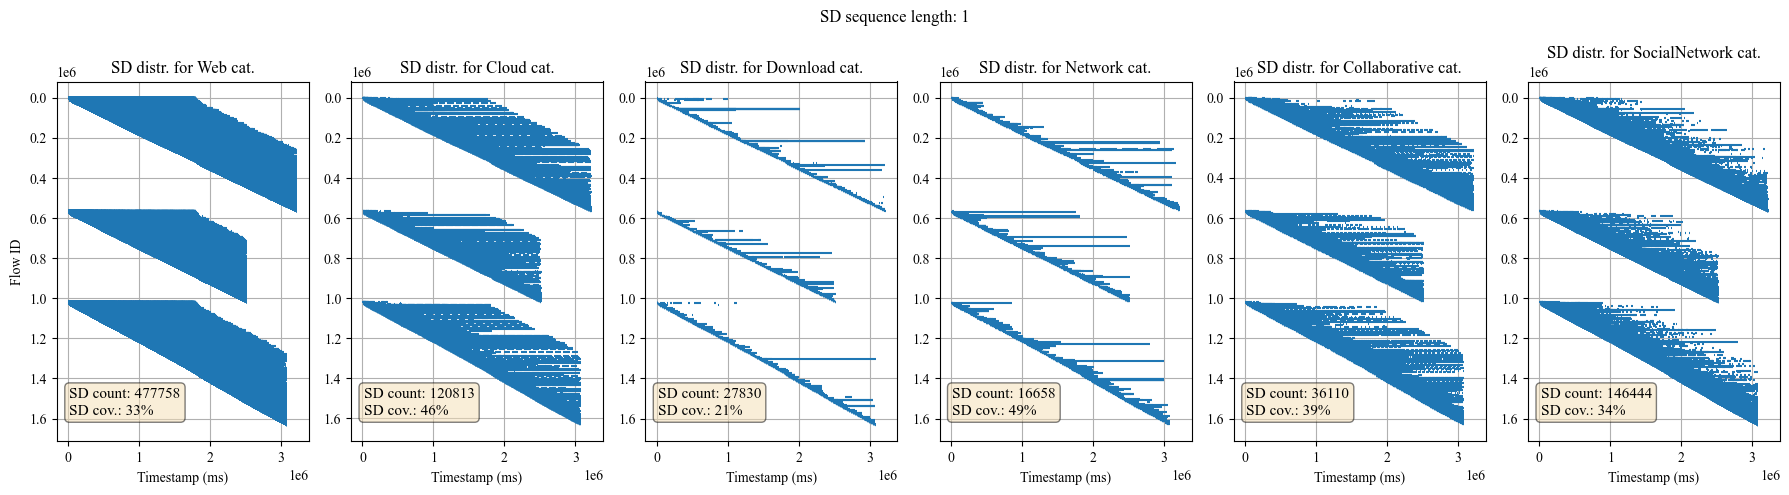

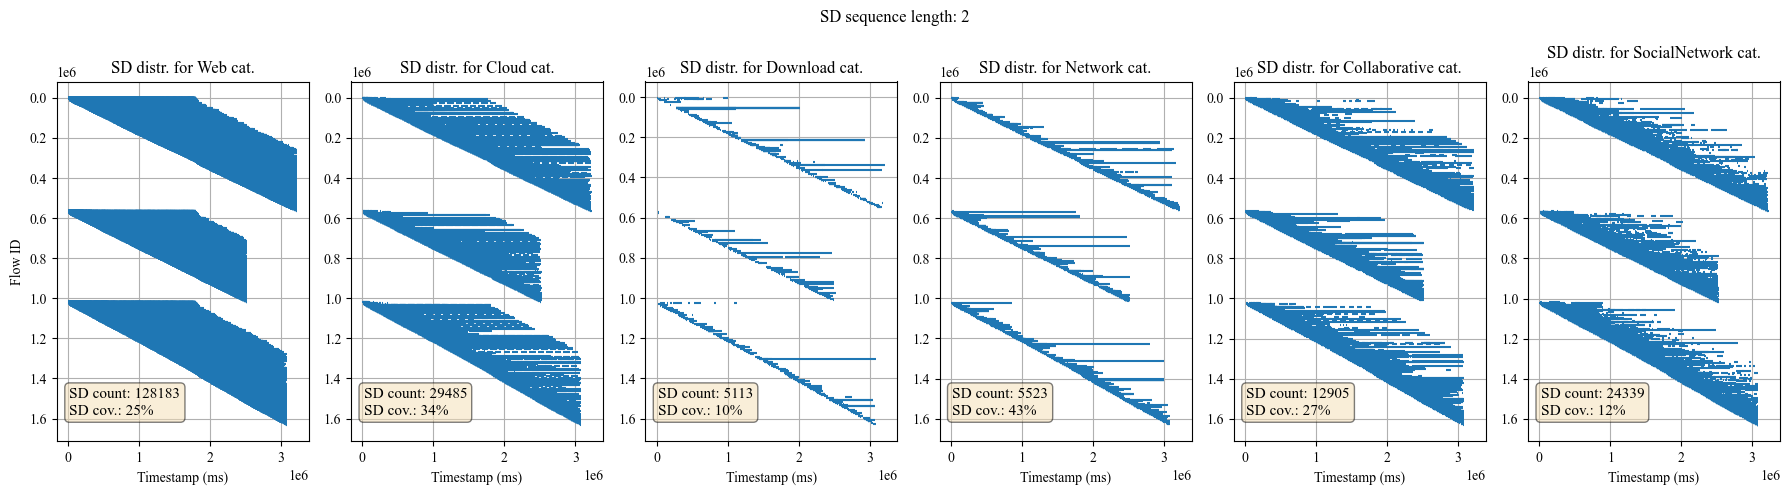

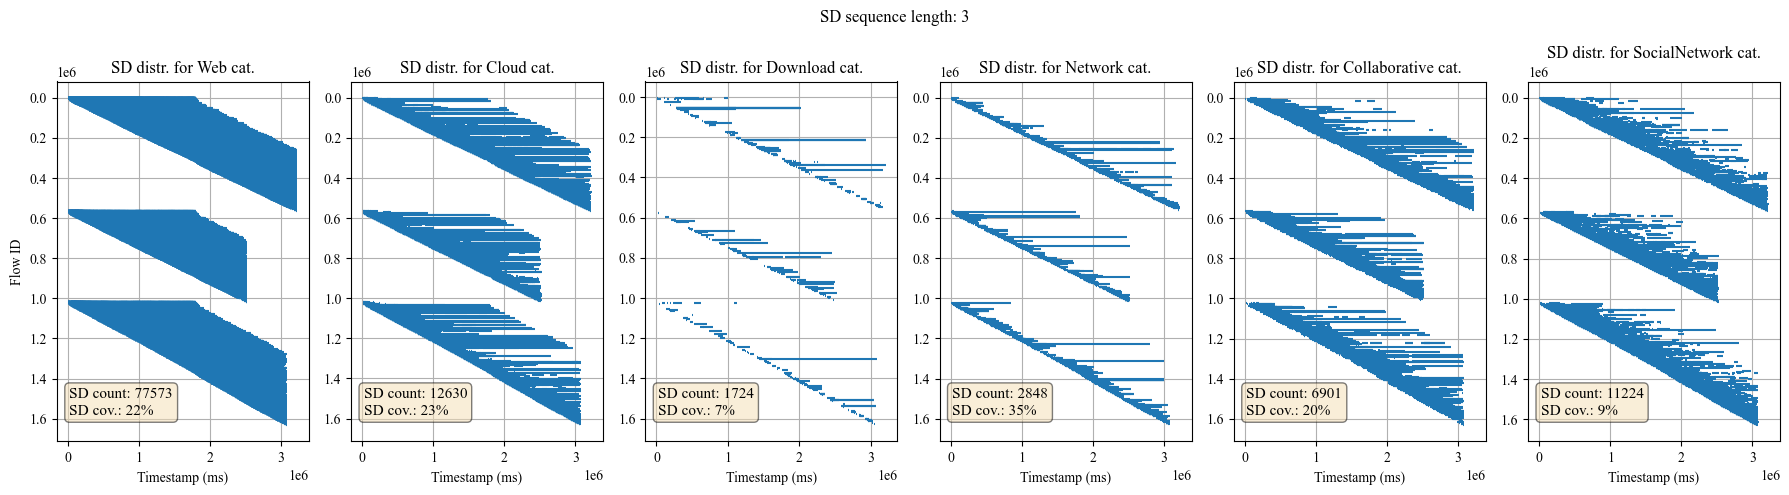

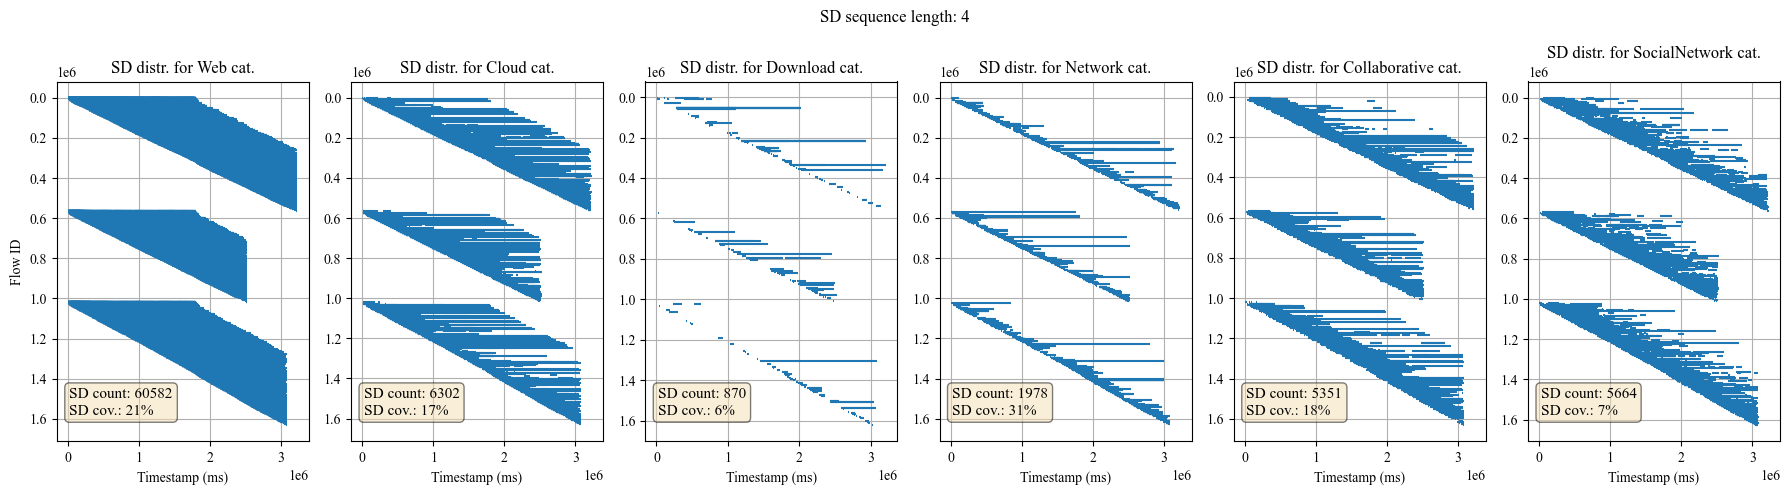

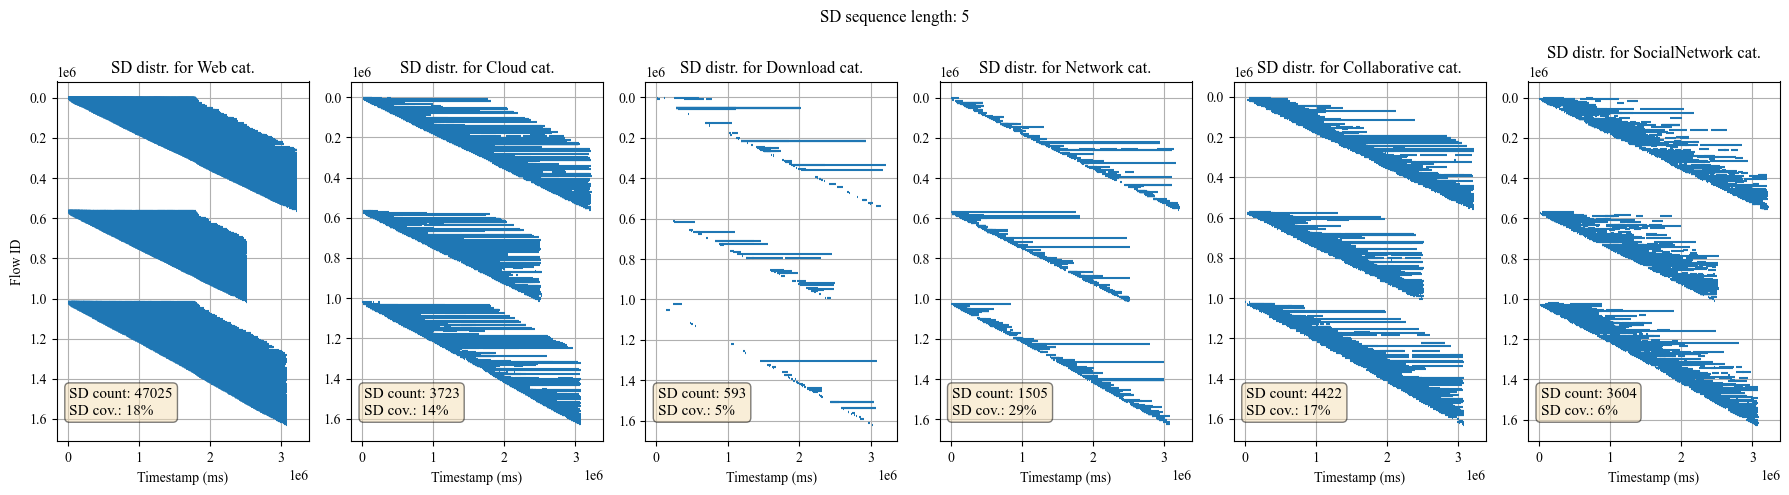

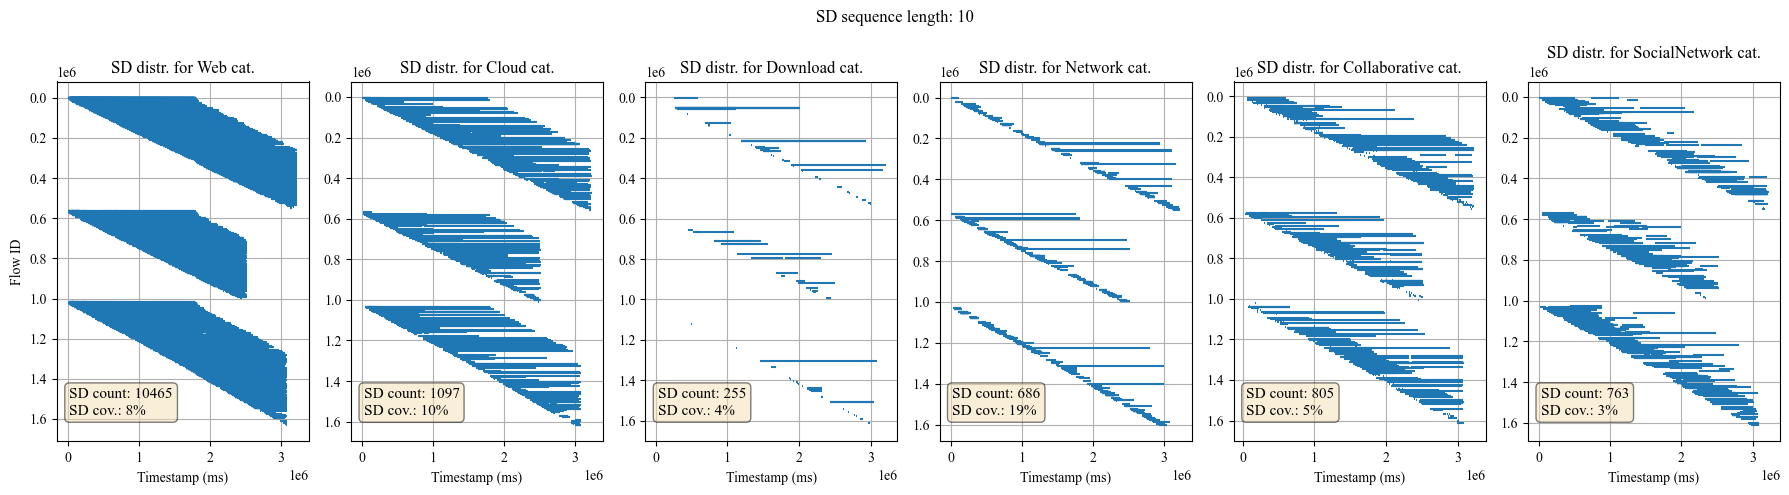

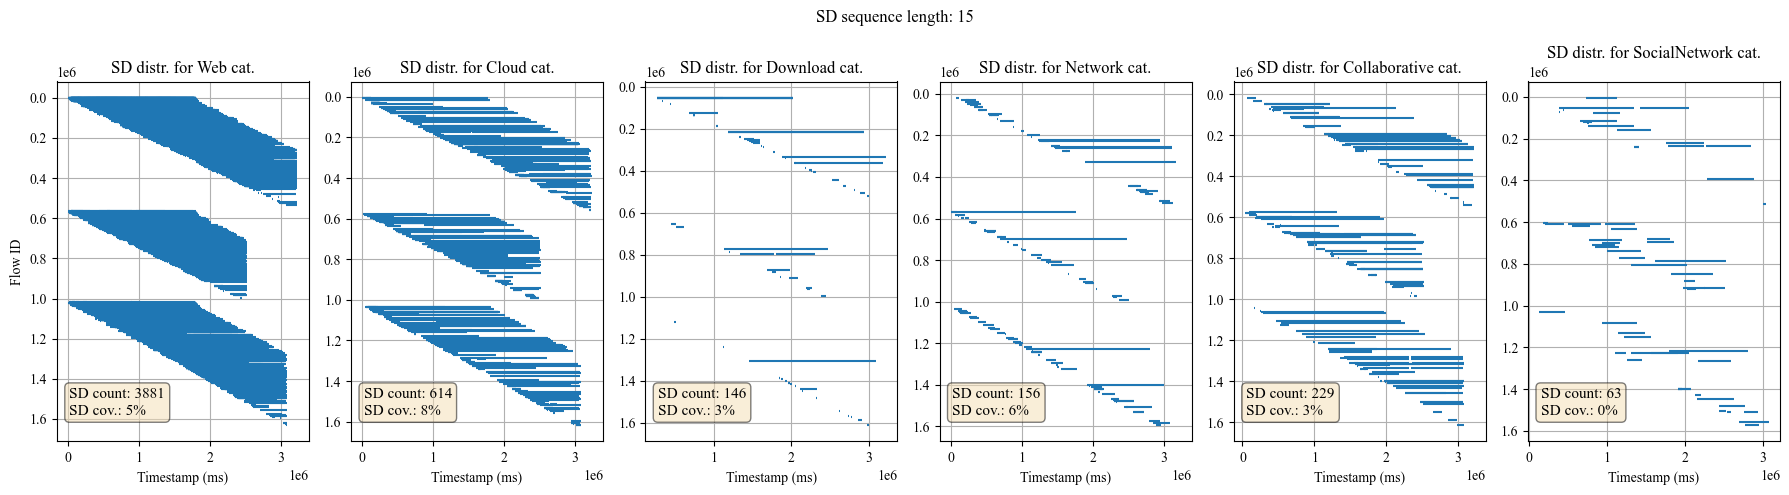

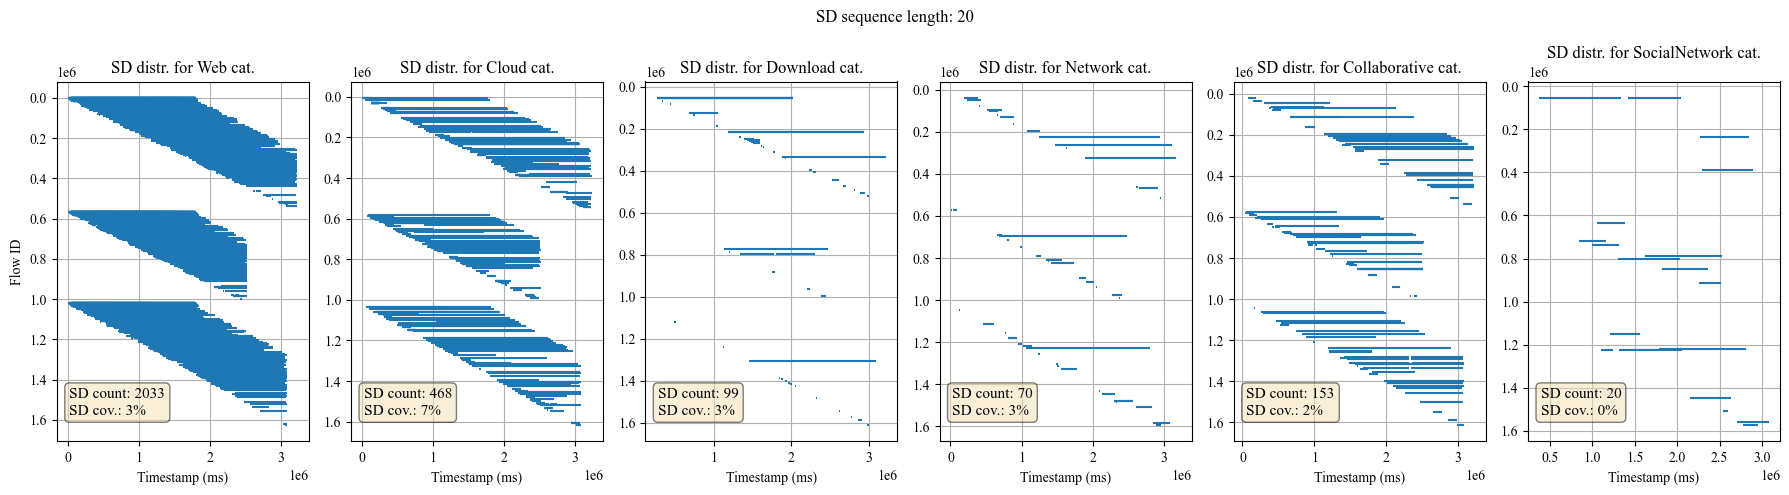

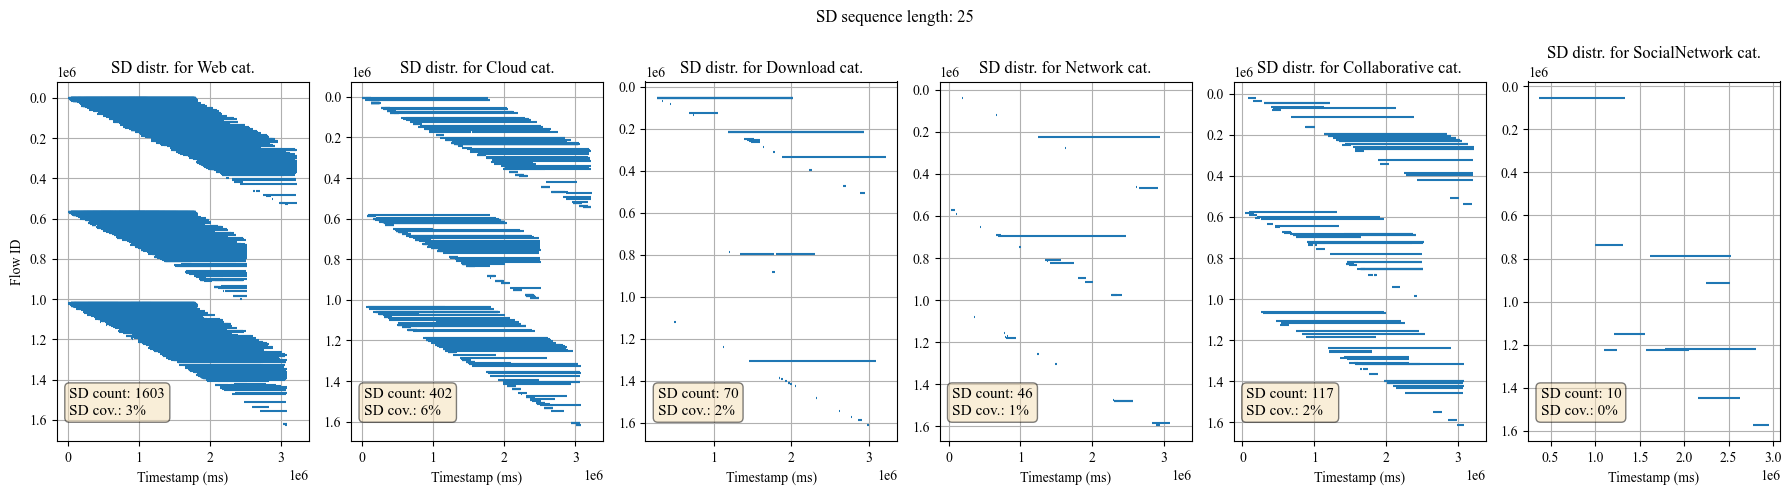

In [24]:
for seq_len in [1, 2, 3, 4, 5, 10, 15, 20, 25]:
    df_train_all[['Q_SD_sequences_idx', 'Q_SD_sequences', 'Q_SD_sequences_timestamps']] = df_train_all.apply(find_SD_sequences, axis=1, delay_SD_col_name='SDd_by_Q',
                                                                                                             jitter_SD_col_name='SDj_by_Q', MIN_SEQ_LEN=seq_len)
    df_train_all['Q_SD_count'] = df_train_all['Q_SD_sequences_timestamps'].apply(len)
    df_train_all['Q_SD_time'] = df_train_all.apply(lambda row: sum([end - start for (start, end) in row['Q_SD_sequences_timestamps']]), axis=1)

    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(18, 5))
    
    for idx, a in enumerate(ax.flatten()):
        appcat = df_train_all['application_category_name'].unique()[idx]
        subcat_df = df_train_all[df_train_all['application_category_name'] == appcat]
    
        for row_idx, row in subcat_df.iterrows():
            for SDs, SDe in row['Q_SD_sequences_timestamps']:
                a.hlines(y=row_idx, xmin=SDs, xmax=SDe)
    
        a.set_xlabel('Timestamp (ms)')
        if idx == 0:
            a.set_ylabel('Flow ID')
        a.invert_yaxis()
        a.set_title(f'SD distr. for {appcat} cat.')
        a.grid(True)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)                                                   
        text = f"SD count: {sum(subcat_df['Q_SD_count'])}\nSD cov.: {sum(subcat_df['Q_SD_time']) / sum(subcat_df['LAN_time']):.0%}"
        a.text(0.05, 0.15, text, transform=a.transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
    
    plt.suptitle(f"SD sequence length: {seq_len}")
    plt.tight_layout()
    plt.savefig(f'plots/SDanalysis/IQR_sequence_analysis_D_seq{seq_len}.pdf')
    plt.show()

We observe that in the case that the singular SD events allowed (i.e. a minimum sequence length of 1) the start of the flows tend to be marked with SD events. This is more apparent in the case of flows with fewer SD events like *Download*, where this dominant behavior dissappears for `MIN_SEQ_LEN == 5` but it can also be appreciated for *Web* flows as the start of the SD events become more jagged from 10-(or 15-)delay-long sequences.

We see a falling trend in SD event counts and coverage percentages as expected. For all but the *Cloud* category* the SD event coverage falls below 5% leaving only a handful of SD events in comparison to all flows.

### Examining SD Events For Prolonged High Delay and Jitter Scenarios

Execute the analysis once more, this time with the `require_jitter_for_sequence` option set to True. This - adittionally to the high delay - requires the jitter to be high in order to grow a sequence by a delay sample.

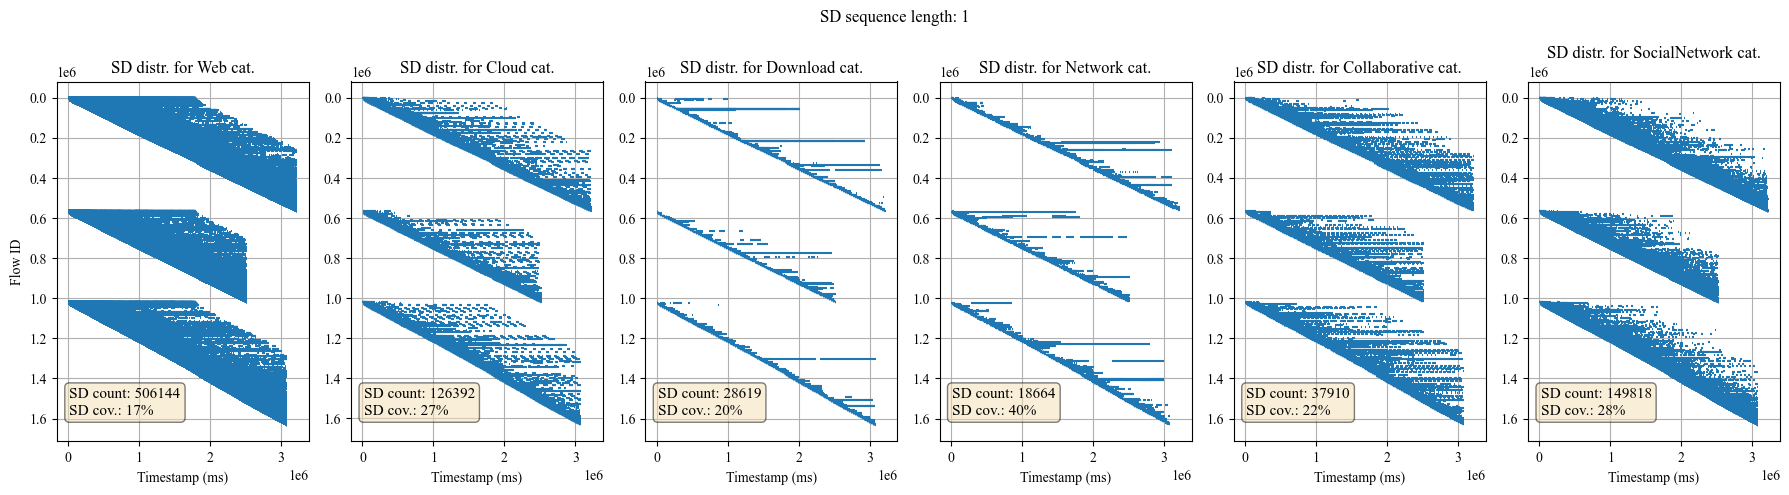

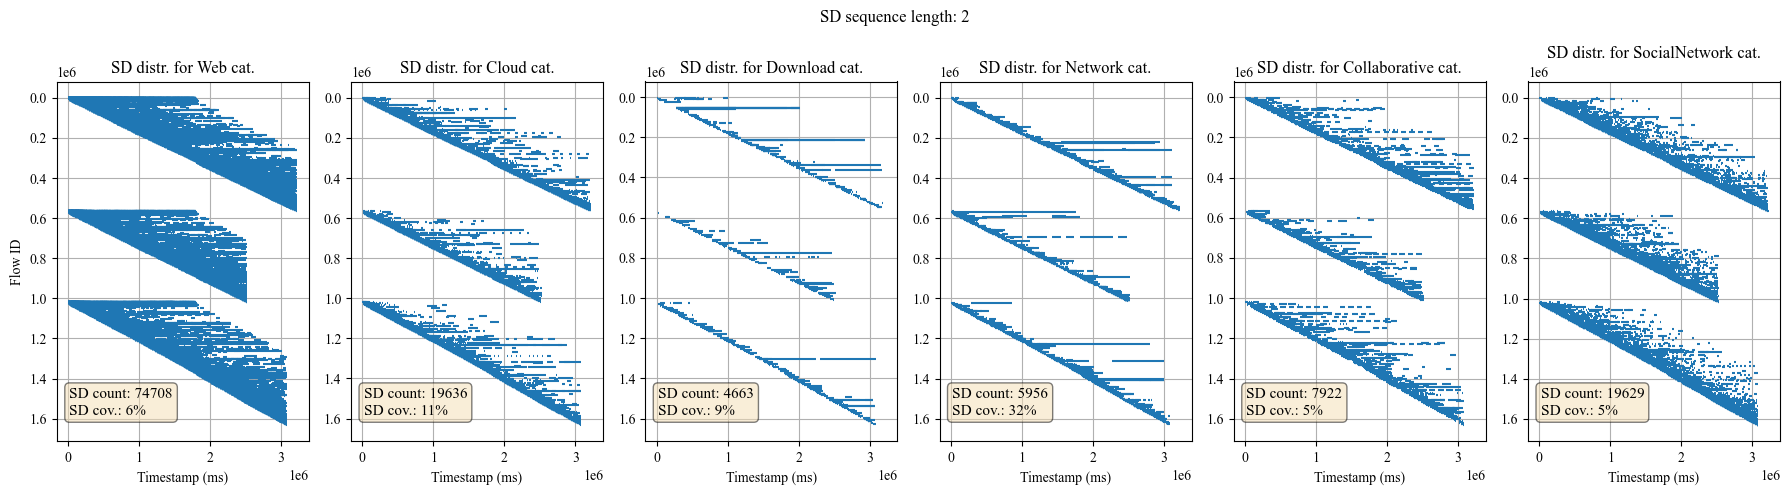

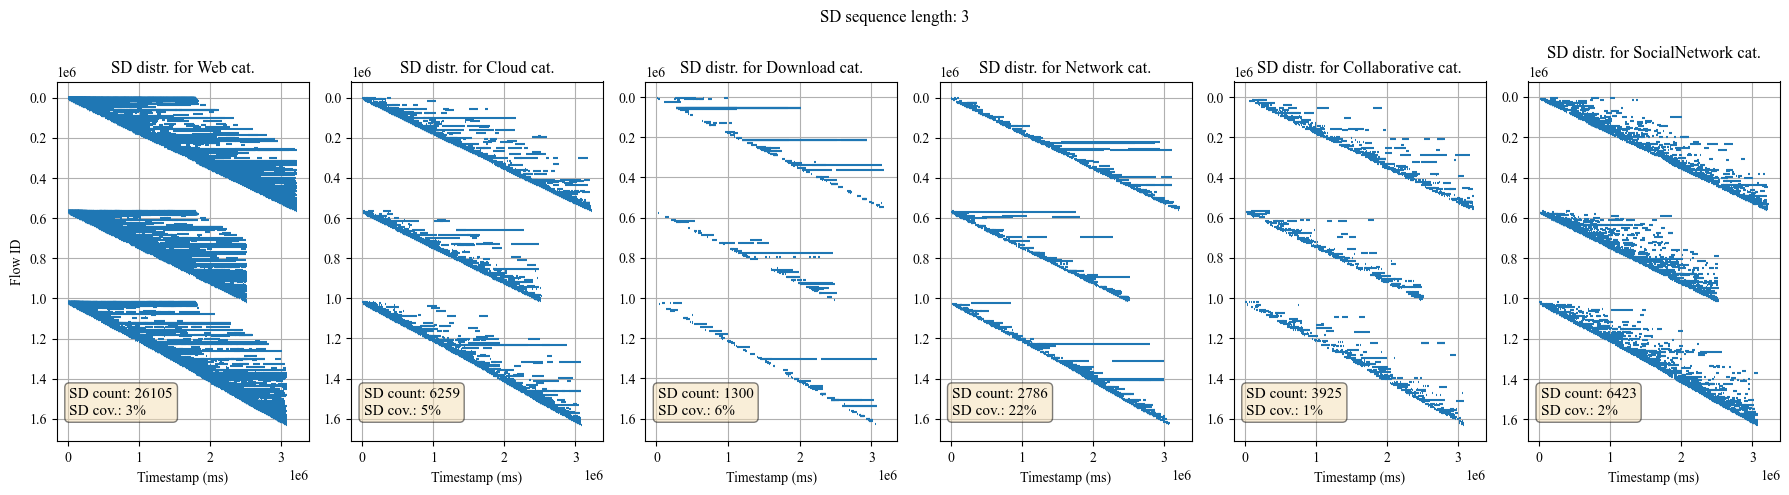

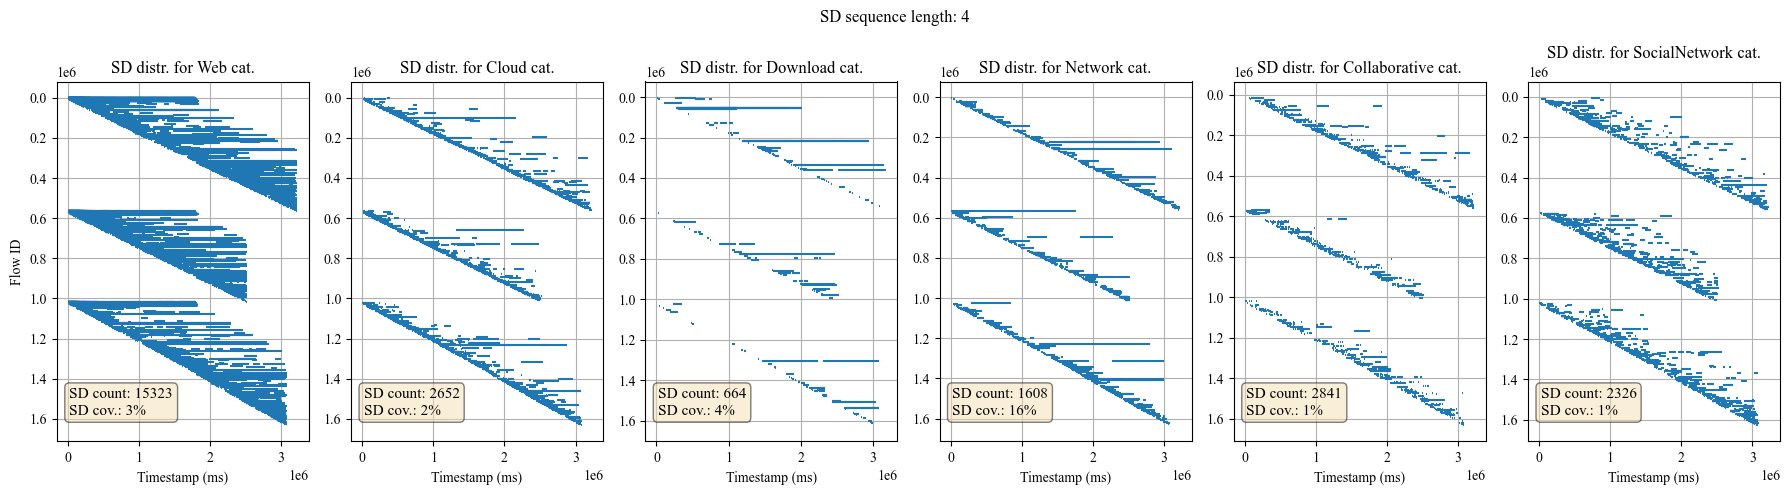

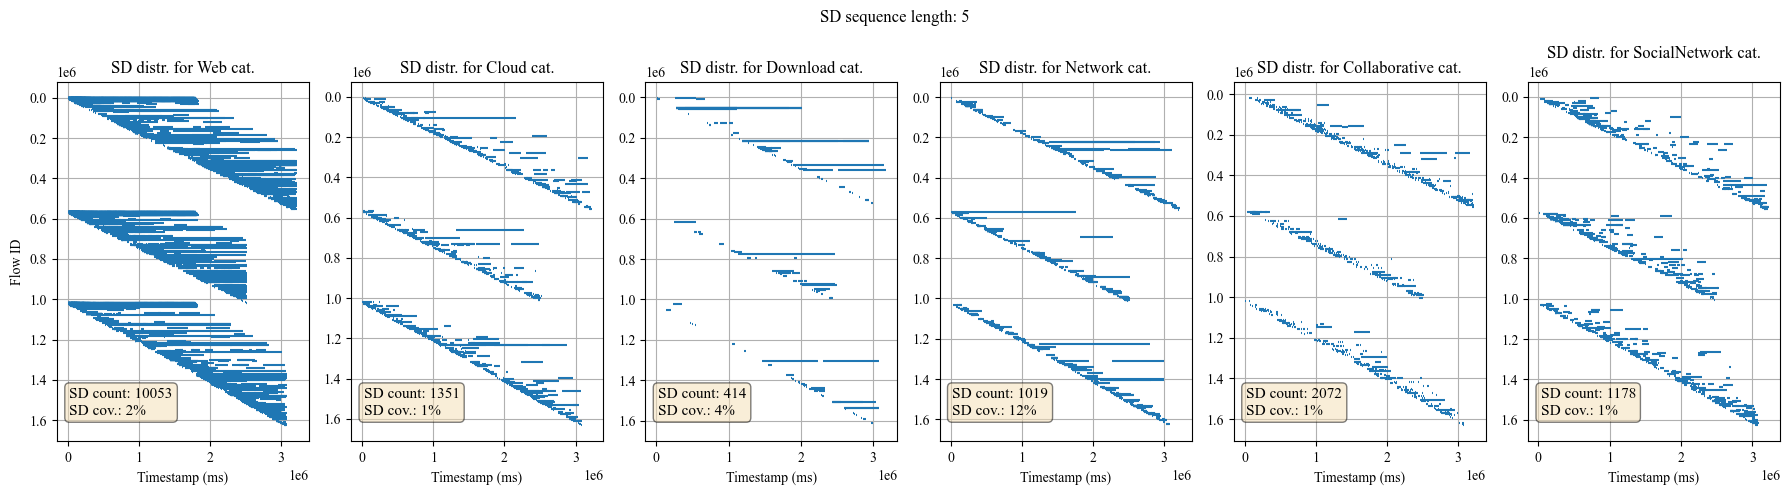

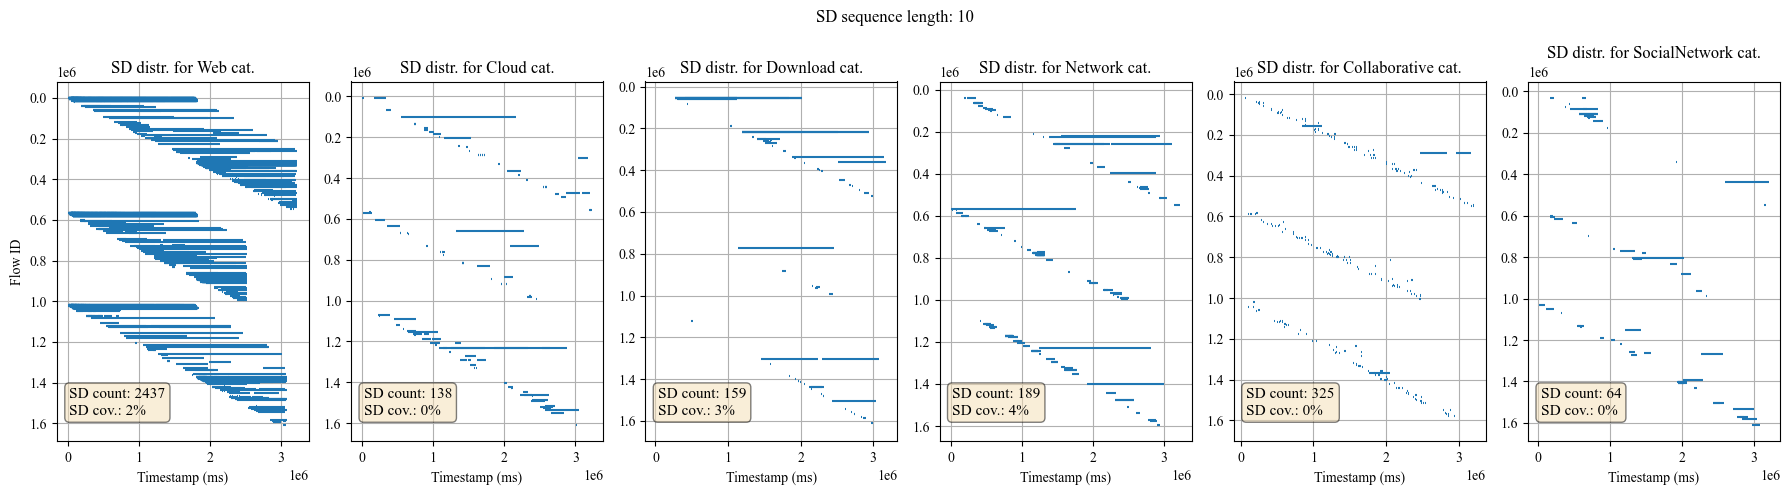

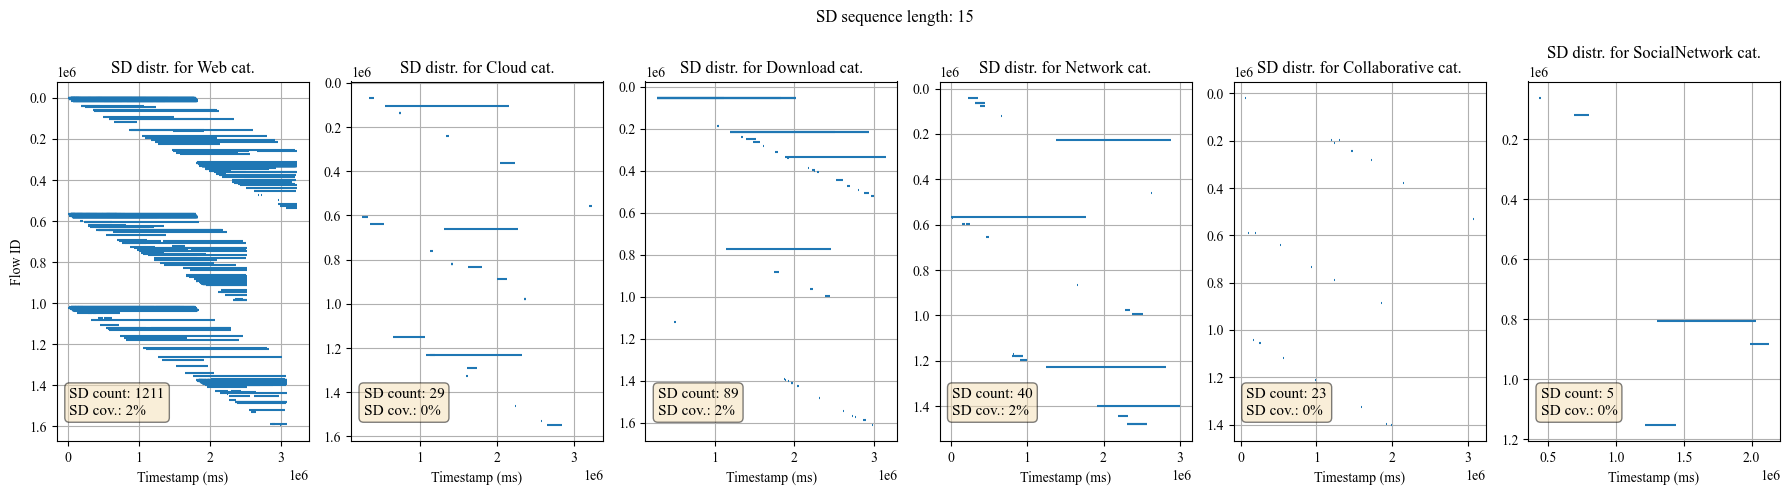

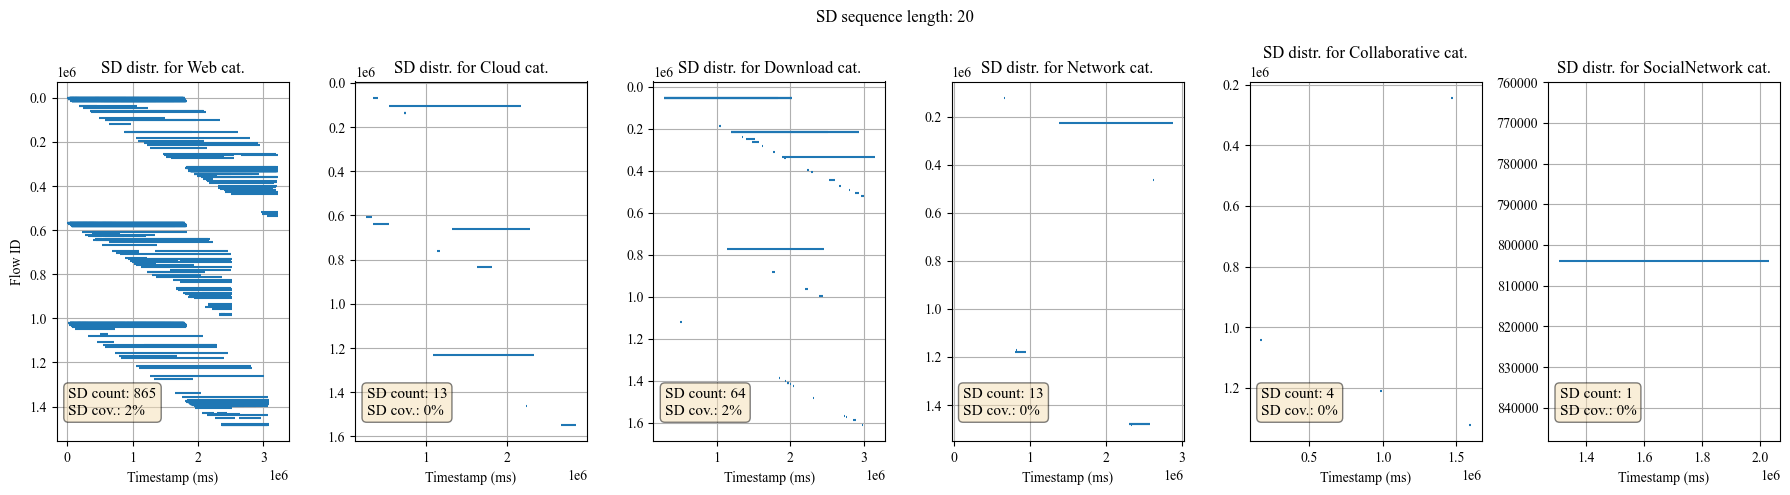

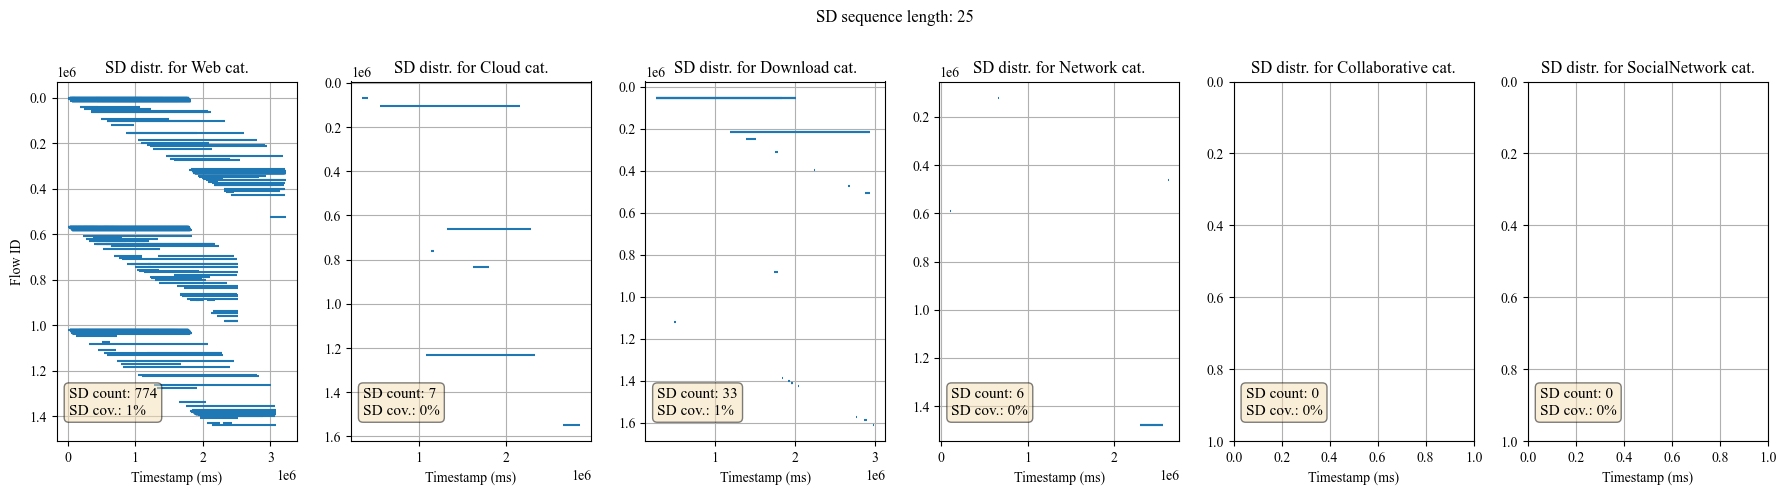

In [25]:
for seq_len in [1, 2, 3, 4, 5, 10, 15, 20, 25]:
    df_train_all[['Q_SD_sequences_idx', 'Q_SD_sequences', 'Q_SD_sequences_timestamps']] = df_train_all.apply(find_SD_sequences, axis=1, delay_SD_col_name='SDd_by_Q',
                                                                                                             jitter_SD_col_name='SDj_by_Q', MIN_SEQ_LEN=seq_len,
                                                                                                             require_jitter_for_sequence=True)
    df_train_all['Q_SD_count'] = df_train_all['Q_SD_sequences_timestamps'].apply(len)
    df_train_all['Q_SD_time'] = df_train_all.apply(lambda row: sum([end - start for (start, end) in row['Q_SD_sequences_timestamps']]), axis=1)

    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(18, 5))
    
    for idx, a in enumerate(ax.flatten()):
        appcat = df_train_all['application_category_name'].unique()[idx]
        subcat_df = df_train_all[df_train_all['application_category_name'] == appcat]
    
        for row_idx, row in subcat_df.iterrows():
            for SDs, SDe in row['Q_SD_sequences_timestamps']:
                a.hlines(y=row_idx, xmin=SDs, xmax=SDe)
    
        a.set_xlabel('Timestamp (ms)')
        if idx == 0:
            a.set_ylabel('Flow ID')
        a.invert_yaxis()
        a.set_title(f'SD distr. for {appcat} cat.')
        a.grid(True)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)                                                   
        text = f"SD count: {sum(subcat_df['Q_SD_count'])}\nSD cov.: {sum(subcat_df['Q_SD_time']) / sum(subcat_df['LAN_time']):.0%}"
        a.text(0.05, 0.15, text, transform=a.transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
    
    plt.suptitle(f"SD sequence length: {seq_len}")
    plt.tight_layout()
    plt.savefig(f'plots/SDanalysis/IQR_sequence_analysis_DJ_seq{seq_len}.pdf')
    plt.show()

In [26]:
'''
In case of modified run, the configuration with MIN_SEQ_LEN=25 and require_jitter_for_sequence=True
may be necessary for correct behavior in further analysis.
Otherwise this cell can be left commented out
'''

# df_train_all[['Q_SD_sequences_idx', 'Q_SD_sequences', 'Q_SD_sequences_timestamps']] = df_train_all.apply(find_SD_sequences, axis=1, delay_SD_col_name='SDd_by_Q',
#                                                                                                          jitter_SD_col_name='SDj_by_Q', MIN_SEQ_LEN=25,
#                                                                                                          require_jitter_for_sequence=True)
# df_train_all['Q_SD_count'] = df_train_all['Q_SD_sequences_timestamps'].apply(len)
# df_train_all['Q_SD_time'] = df_train_all.apply(lambda row: sum([end - start for (start, end) in row['Q_SD_sequences_timestamps']]), axis=1)

The findings here are similar. We see that the number of SD events at `MIN_SEQ_LEN == 1` is sligthly larger than before. This is due to the fact that the sequences become shorter when they are broken by delays where jitter is small, resulting in shorter but more numerous sequences. This is reflected in the lower overall SD coverage as well.

Beyond this sequence length the SD event count is drastically reduced again by requiring longer and longer minimum sequence lengths. Here however, we see a quicker change, i.e. by `MIN_SEQ_LEN == 10` we already see the low coverage previously only achieved by sequences of length 25, in this case all application categories dipping below 5% coverage. This time the *Network* category is the one that maintains a higher time coverage by SD events, at `MIN_SEQ_LEN == 4` only this categoriy was over 10%, all the others already fall below 5% coverage.

# Z-score Analysis

Another way of simple outlier detection is the Z-score. The Z-score is a measure of how far away a data point is from the mean, in terms of standard deviations. 

It's defined as:$Z=\frac{X-\mu}{\sigma}$
where:
* $X$ is the data point.
* $μ$ is the mean of the data.
* $σ$ is the standard deviation of the data.

A high absolute value of the Z-score indicates that the data point is far from the mean. Traditionally, data points with Z-scores greater than 2 or 3 (in absolute value) are considered outliers.

For our case, since we're looking for service degradation, which would be represented by unusually large delays, we should particularly look for positive Z-scores (indicating values greater than the mean). The suitable threshold for considering a delay as an indication of service degradation can vary based on the category and the specific characteristics of the data.cteristics of the data.

## Examining Data Distribution

For the Z-score Analysis instead of focusing on the percentile values of the data, the focus is placed on the mean and the standard deviation. We plot the $mean$ and the $Z=1$, $Z=2$ and $Z=3$ for all application categories (for delay as well as jitter values), where $Z$ stands for the Z-score in the positive direction, i.e. it marks the positive distance from the mean in steps of standard deviation. The base of the plot is the same boxplot we used for Quartile Analysis to facilitate comparison.

Mean values are marked with an orange diamond, $Z=1$, $Z=2$ and $Z=3$ with orange, coral and red horizontal lines respectively.

In [27]:
# Change datatype for the data column so that the mean and standard deviation can be carried out
df_exploded = df_exploded.astype({'Delay / Jitter [ms]': 'int64'})
df_exploded.dtypes

index                         int64
application_category_name    object
Delay / Jitter [ms]           int64
Metric                       object
dtype: object

C:\Users\Dev\AppData\Local\Temp\ipykernel_12316\3350717003.py:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


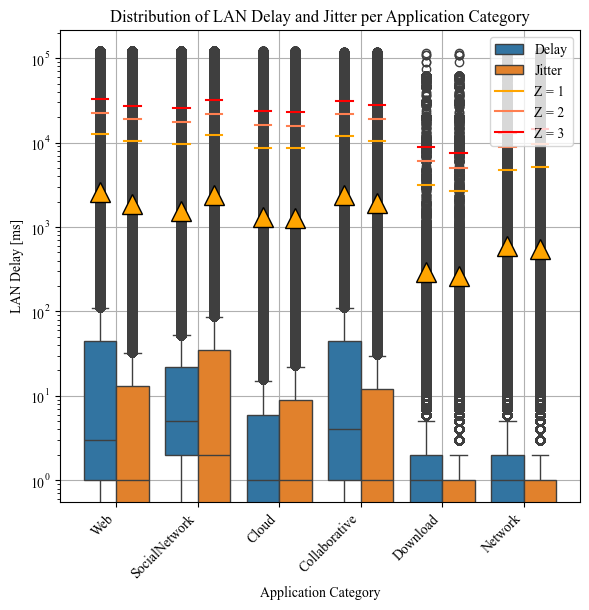

In [28]:
# Visualize the distribution of metrics for each category using boxplots
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x='application_category_name',
                 y='Delay / Jitter [ms]',
                 hue='Metric',
                 data=df_exploded,
                 order=total_delays_per_category.index,
                 showmeans=True,
                 meanprops={"marker":"^",
                             "markerfacecolor":"orange", 
                             "markeredgecolor":"black",
                             "markersize":"15"})
 
# Calculate mean and standard deviation for each group/hue combination
grouped = df_exploded.groupby(['application_category_name', 'Metric'])
means_stds = grouped['Delay / Jitter [ms]'].agg(['mean', 'std'])
# Calculate mean + 3*standard_deviation
means_stds['mean_plus_1std'] = means_stds['mean'] + 1 * means_stds['std']
means_stds['mean_plus_2std'] = means_stds['mean'] + 2 * means_stds['std']
means_stds['mean_plus_3std'] = means_stds['mean'] + 3 * means_stds['std']
# Get unique hues for plotting
hues = df_exploded['Metric'].unique()
# Plot mean + 3*standard_deviation
for position, group in enumerate(total_delays_per_category.index):
    for hue in hues:
        # Find the position of the boxplot
        start = position - 0.3 if hue == 'Delay' else position + 0.1
        end = position - 0.1 if hue == 'Delay' else position + 0.3
        # Get mean + 3*std value
        mean_plus_1std = means_stds.loc[(group, hue), 'mean_plus_1std']
        mean_plus_2std = means_stds.loc[(group, hue), 'mean_plus_2std']
        mean_plus_3std = means_stds.loc[(group, hue), 'mean_plus_3std']
        # Draw a line for the Z-scores 1, 2 and 3
        ax.plot([start, end], [mean_plus_1std, mean_plus_1std], color='orange', label='Z = 1')
        ax.plot([start, end], [mean_plus_2std, mean_plus_2std], color='coral', label='Z = 2')
        ax.plot([start, end], [mean_plus_3std, mean_plus_3std], color='red', label='Z = 3')

plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel('LAN Delay [ms]')
plt.xlabel('Application Category')
plt.tight_layout()
plt.grid()
legend_without_duplicate_labels(ax, loc='upper right')
plt.tight_layout()
# plt.savefig('plots/SDanalysis/Z_score_analysis_loc2.pdf')
plt.savefig('plots/SDanalysis/Z_score_analysis_loc2.png', dpi=500)
plt.title('Distribution of LAN Delay and Jitter per Application Category')
plt.show()

We can observe that the Z-scores follow a similar distribution as the mean values do. The *Web*, *Social Network*, *Cloud* and *Collaborative* categories have similar Z-score limits with the $Z=3$ limit going beyond 20 seconds. The *Download* category just falls short of 10 seconds, while *Network* has its corresponding limit at a bit higher than 10 seconds both in delay and jitter.

The plot illustrates well the stricter nature of the Z-score Analysis. While with the Quartile Analysis the singular delay SD events (marked with black circles as outliers beyond whiskers) has a much larger cardinality owing to the lower limit (the upper whisker defined by the corresponding IQR), Z-score Analysis instead lays on the -- in most cases already larger -- mean of delays and goes beyond this. As a result, there are significantly less singular delay SD events identified by Z-score Analysis. Such identified events are the ones higher than the Z-score. In line with the practice applied by anomaly detection work using the Z-score analysis, we opt for $Z=3$ as the Z-score limit.

## Calculating Z-scores

Let's perform the same analysis as we did with Quartile Analysis, first marking singular SD events both in terms of delay and jitter and going on to study potential SD sequences.

In [29]:
df_z_scores_delays = pd.DataFrame()
df_z_scores_jitter = pd.DataFrame()
df_mean_std_for_app_cats = pd.DataFrame(index=['D_mean', 'D_std', 'J_mean', 'J_std'])

for app_cat in df_train_all['application_category_name'].unique():
    group_delays = df_train_all[df_train_all['application_category_name'] == app_cat]['LAN_delay'].explode()
    group_jitter = df_train_all[df_train_all['application_category_name'] == app_cat]['LAN_jitter'].explode()
    
    # Compute Z-scores for each delay value
    delay_mean = np.mean(group_delays.to_list())
    delay_std = np.std(group_delays.to_list())
    jitter_mean = np.mean(group_jitter.to_list())
    jitter_std = np.std(group_jitter.to_list())
    df_mean_std_for_app_cats[app_cat] = [delay_mean, delay_std, jitter_mean, jitter_std]
    group_delay_z_scores = [(x - delay_mean) / delay_std  for x in group_delays.to_list()]
    group_jitter_z_scores = [(x - jitter_mean) / jitter_std for x in group_jitter.to_list()]

    df_group_delays = pd.DataFrame(group_delays).reset_index()
    df_group_jitter = pd.DataFrame(group_jitter).reset_index()
    df_group_delays['z_scores'] = group_delay_z_scores
    df_group_jitter['z_scores'] = group_jitter_z_scores
    df_z_scores_delays = pd.concat([df_z_scores_delays, df_group_delays])
    df_z_scores_jitter = pd.concat([df_z_scores_jitter, df_group_jitter])

In [30]:
df_mean_std_for_app_cats

Web        Cloud     Download      Network  Collaborative  \
D_mean   2566.862155  1298.987083   294.114976   592.488681    2403.653084   
D_std   10027.893136  7358.914291  2887.640367  4166.061734    9668.427904   
J_mean   1893.552525  1277.335015   265.786786   551.511982    1921.770279   
J_std    8464.724046  7279.632003  2389.940381  4588.307202    8560.043801   

        SocialNetwork  
D_mean    1559.435771  
D_std     8011.103403  
J_mean    2424.248155  
J_std     9751.157001

In [31]:
df_z_scores_delays = df_z_scores_delays.reset_index()
df_z_scores_jitter = df_z_scores_jitter.reset_index()
df_z_scores_delays.sort_values(['index', 'level_0'], inplace=True) # sorting first by index (original flow index), than by level_0 order in the flow)
df_z_scores_jitter.sort_values(['index', 'level_0'], inplace=True)
df_z_scores_delays['SD_by_Z'] = df_z_scores_delays['z_scores'].apply(lambda x: True if x > 3 else False)
df_z_scores_jitter['SD_by_Z'] = df_z_scores_jitter['z_scores'].apply(lambda x: True if x > 3 else False)

df_train_all['SDd_by_Z'] = df_z_scores_delays.groupby('index').agg({'SD_by_Z': lambda x: x.tolist()})
df_train_all['SDj_by_Z'] = df_z_scores_jitter.groupby('index').agg({'SD_by_Z': lambda x: x.tolist()})

In [32]:
df_z_scores_exploded = df_train_all.apply(lambda row: [row['SDd_by_Z'][i] and row['SDj_by_Z'][i] for i in range(len(row['SDd_by_Z']))], axis=1).explode()
len_Z_d = len(df_z_scores_delays[df_z_scores_delays['SD_by_Z']])
len_Z_j = len(df_z_scores_jitter[df_z_scores_jitter['SD_by_Z']])
len_Z_dj = len(df_z_scores_exploded[df_z_scores_exploded == True])
print(f"Number of delay outliers: {len_Z_d}")
print(f"Number of jitter outliers: {len_Z_j}")
print(f"Number of outliers identified by both metrics simultaneously: {len_Z_dj}")
print(f"Count of all delay samples: {sum(total_delays_per_category)}")
print(f"Total rate of delay outliers: {len_Z_d / sum(total_delays_per_category)}")
print(f"Total rate of jitter outliers: {len_Z_j / sum(total_delays_per_category)}")
print(f"Total rate of intersection outliers: {len_Z_dj / sum(total_delays_per_category)}")

Number of delay outliers: 499656
Number of jitter outliers: 374765
Number of outliers identified by both metrics simultaneously: 194233
Count of all delay samples: 13439632
Total rate of delay outliers: 0.03717780367795785
Total rate of jitter outliers: 0.027885064114850765
Total rate of intersection outliers: 0.01445225583557645


### Examining SD Events For Prolonged High Delay Scenarios

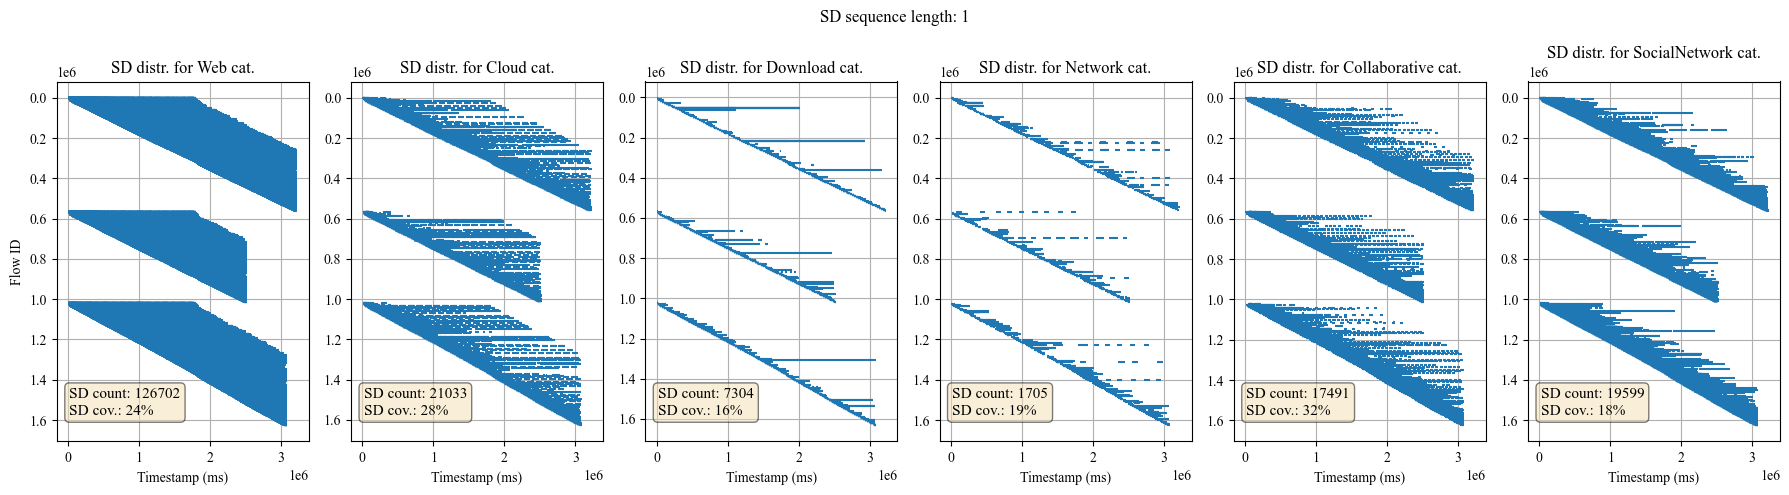

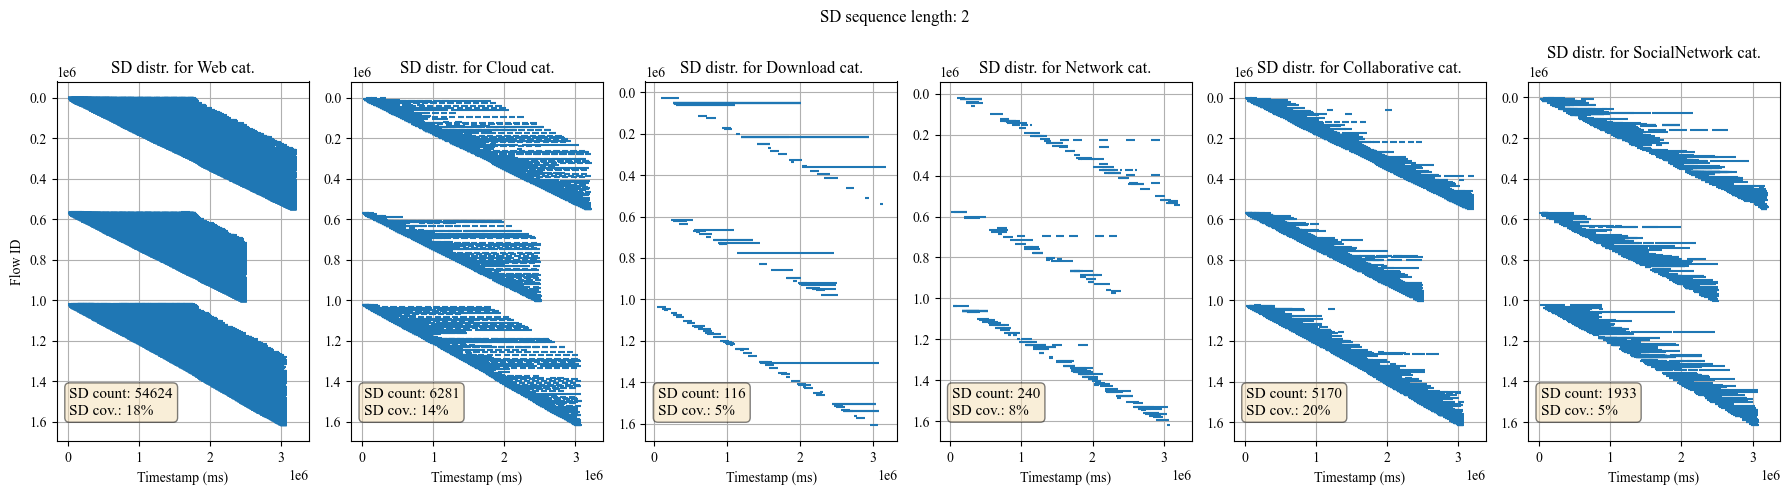

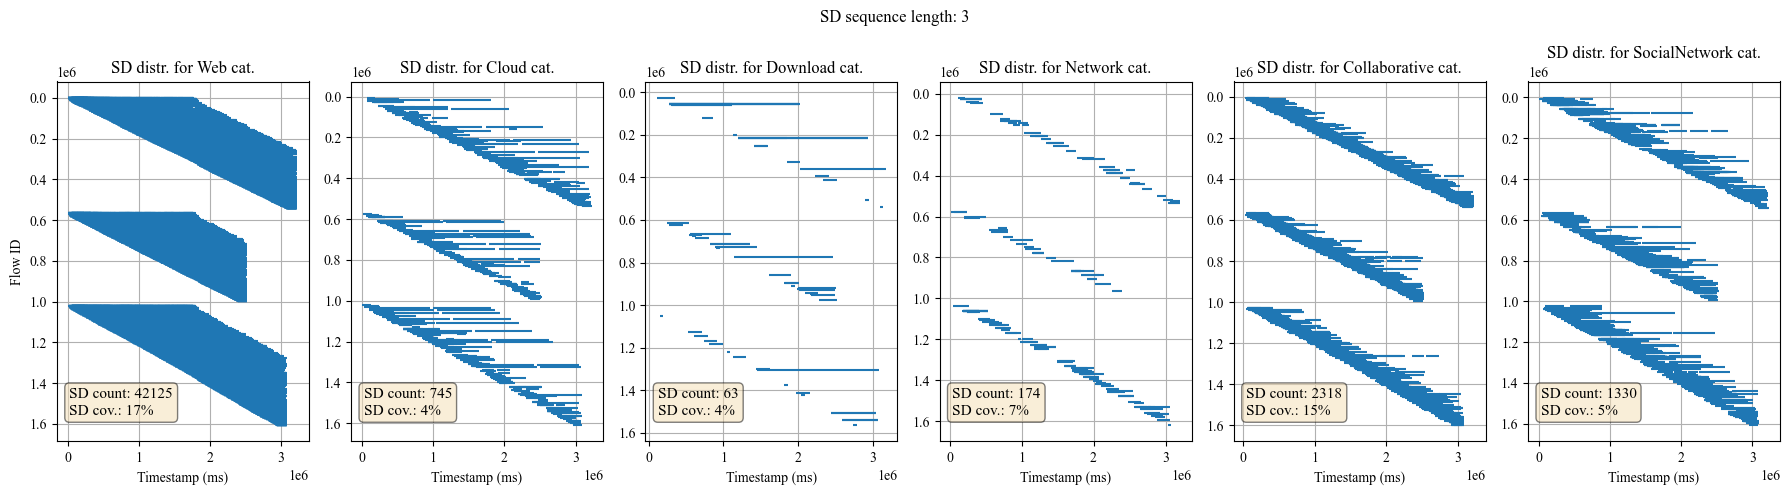

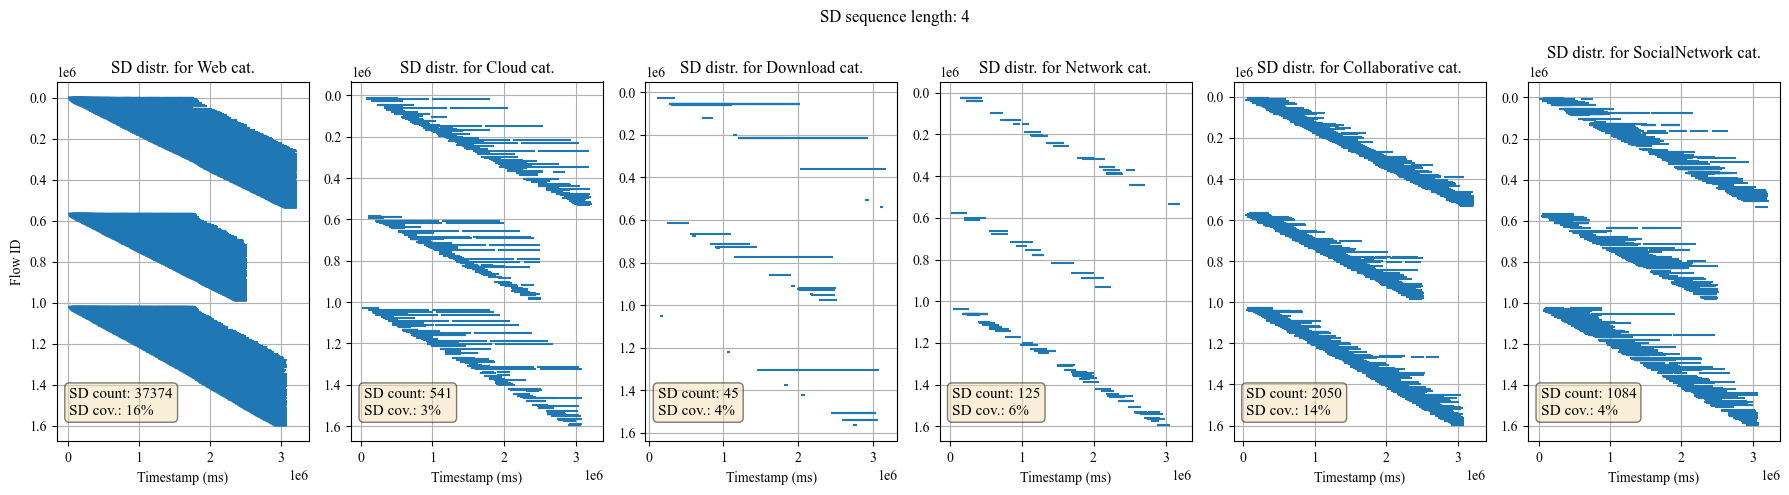

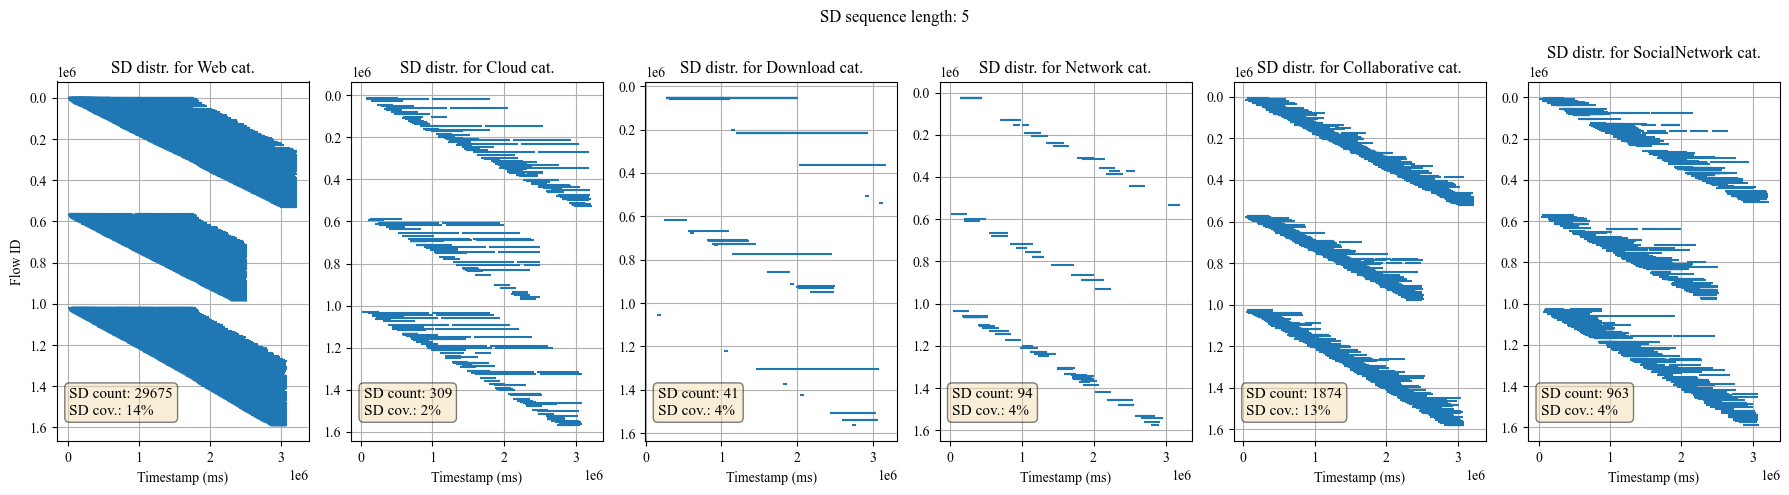

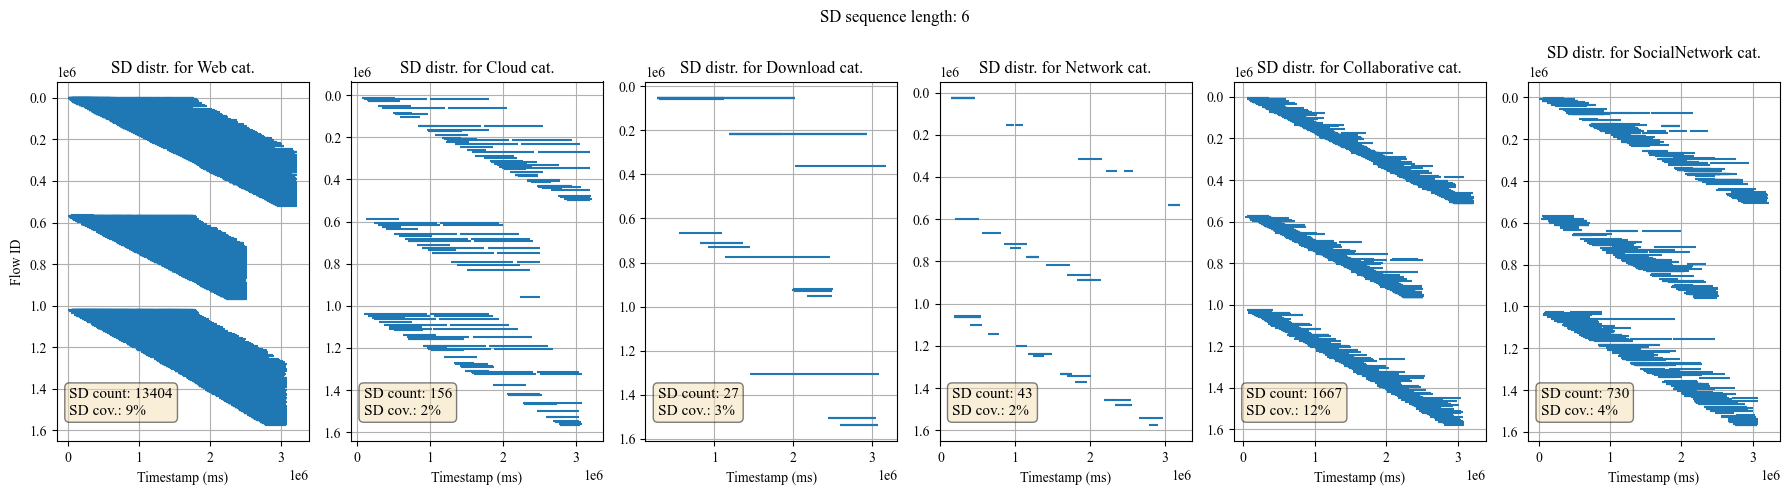

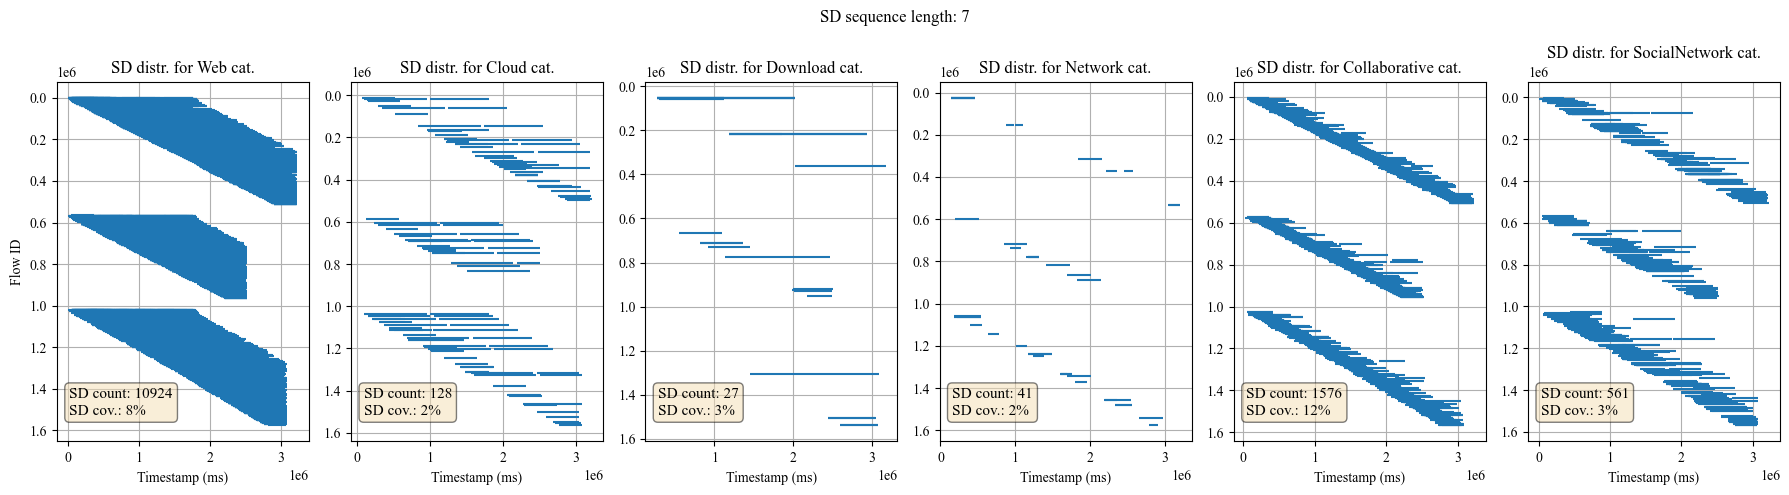

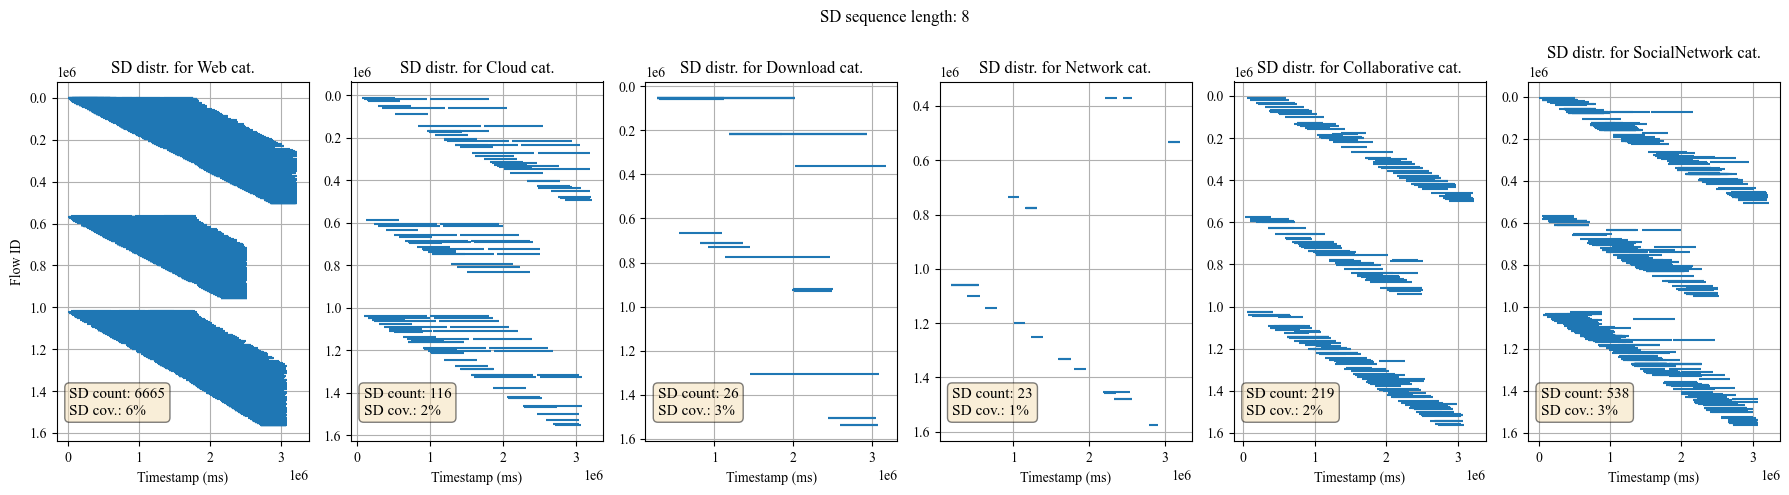

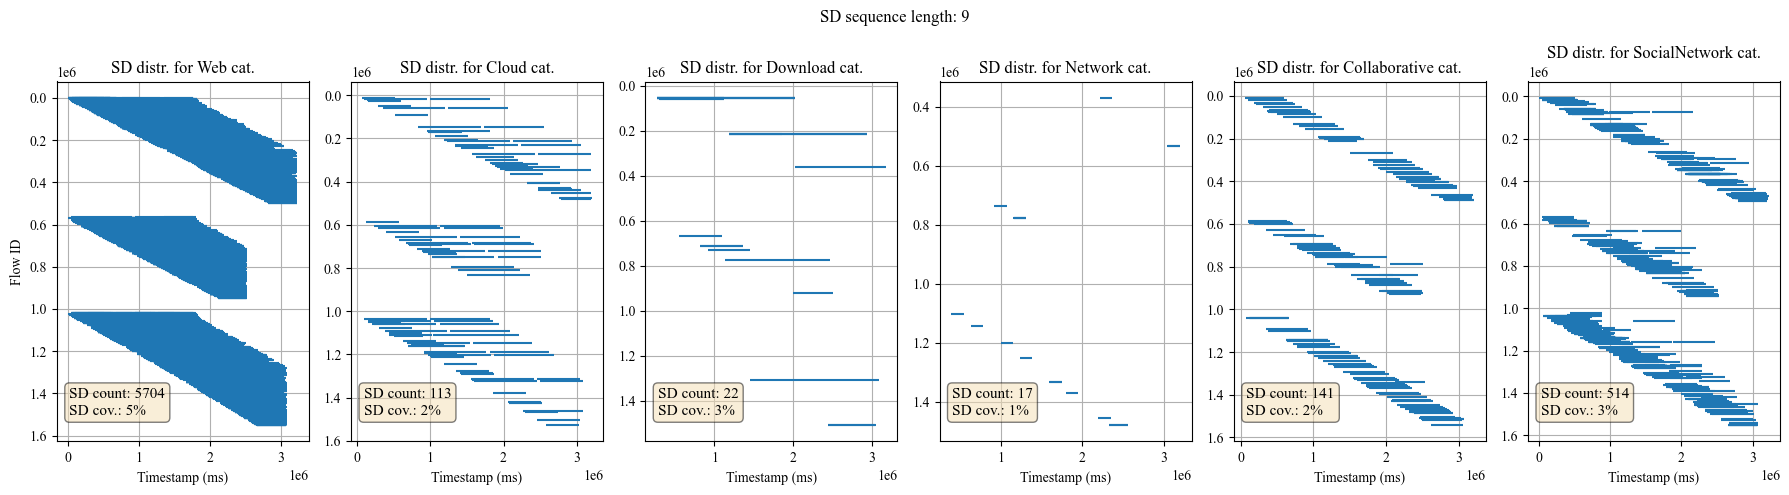

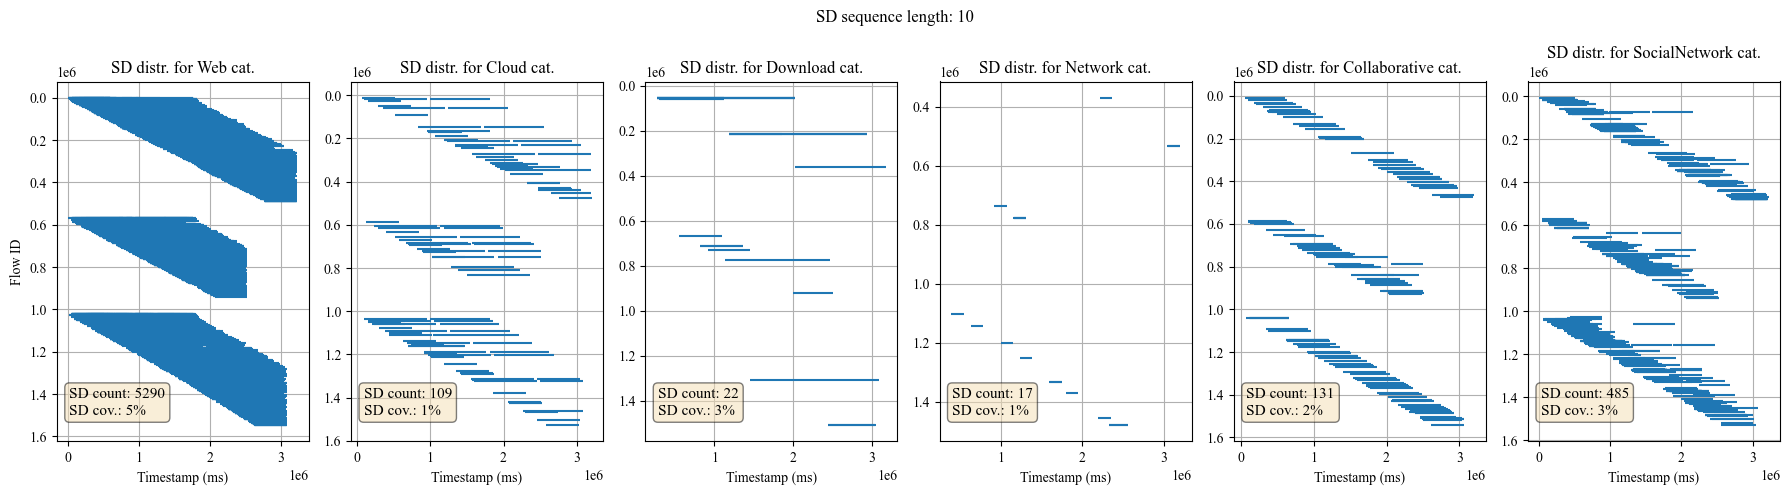

In [33]:
for seq_len in range(1, 11):
    df_train_all[['Z_SD_sequences_idx', 'Z_SD_sequences', 'Z_SD_sequences_timestamps']] = df_train_all.apply(find_SD_sequences, axis=1, delay_SD_col_name='SDd_by_Z', jitter_SD_col_name='SDj_by_Z', MIN_SEQ_LEN=seq_len)
    df_train_all['Z_SD_count'] = df_train_all['Z_SD_sequences_timestamps'].apply(len)
    df_train_all['Z_SD_time'] = df_train_all.apply(lambda row: sum([end - start for (start, end) in row['Z_SD_sequences_timestamps']]), axis=1)

    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(18, 5))
    
    for idx, a in enumerate(ax.flatten()):
        appcat = df_train_all['application_category_name'].unique()[idx]
        subcat_df = df_train_all[df_train_all['application_category_name'] == appcat]
    
        for row_idx, row in subcat_df.iterrows():
            for SDs, SDe in row['Z_SD_sequences_timestamps']:
                a.hlines(y=row_idx, xmin=SDs, xmax=SDe)
    
        a.set_xlabel('Timestamp (ms)')
        if idx == 0:
            a.set_ylabel('Flow ID')
        a.invert_yaxis()
        a.set_title(f'SD distr. for {appcat} cat.')
        a.grid(True)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)                                                   
        text = f"SD count: {sum(subcat_df['Z_SD_count'])}\nSD cov.: {sum(subcat_df['Z_SD_time']) / sum(subcat_df['LAN_time']):.0%}"
        a.text(0.05, 0.15, text, transform=a.transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
    
    plt.suptitle(f"SD sequence length: {seq_len}")
    plt.tight_layout()
    plt.savefig(f'plots/SDanalysis/Z_sequence_analysis_D_seq{seq_len}.pdf')
    plt.show()

In [34]:
SD_cov_l2 = pd.DataFrame({
    'SD_seq_len': range(1, 11),
    'Web': [0.24, 0.18, 0.17, 0.16, 0.14, 0.09, 0.08, 0.06, 0.05, 0.05],
    'Cloud': [0.28, 0.14, 0.04, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01],
    'Download': [0.16, 0.05, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03],
    'Network': [0.19, 0.08, 0.07, 0.06, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01],
    'Collaborative': [0.32, 0.20, 0.15, 0.14, 0.13, 0.12, 0.12, 0.02, 0.02, 0.02],
    'SocialNetwork': [0.18, 0.05, 0.05, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03],
})

With the Z-score Analysis, it is apparent that the initial SD event count and coverage is substantially lower than in the case of Quartile Analysis. Similar patterns, counts and coverages are achieved already by `MIN_SEQ_LEN == 3` with the exception of the *Web* application category which seems to follow a similar pattern to that of the Quartile Analysis. This means that the SD event in this category tend to be more extreme and longer-standing so to be identified by both methods.

The SD events identified at the start of flows is less prevalent and dissappears more quicly. While we still see some of this behavior when allowing one delay long sequences, these are largely absent when restricting to sequence length of 2. This being said, *Web* category still needs a sequence length of at least 6 delays for this behavior to start to subside.

It can also be observed by seeing a sequential increase of sequence length that at a certain sequence length there is a drop in SD coverage of 10% or more. The `MIN_SEQ_LEN` values are 2 for *Download*, *Network* and *Social Network*, 3 for *Cloud*, 8 for *Collaborative*. *Web* does not seem to observe such a drastic drop. This means that just by requiring a minimum sequence length of one more many shorter events drop out and only the longers remain. This length may be a good indicator of the characteristic `MIN_SEQ_LEN` for that application category.

### Examining SD Events For Prolonged High Delay and Jitter Scenarios

For the analysis that requires jitter we only examined 5 as the highest `MIN_SEQ_LEN`, as it is expected that beyond this length no SD sequences will be identified in either category.

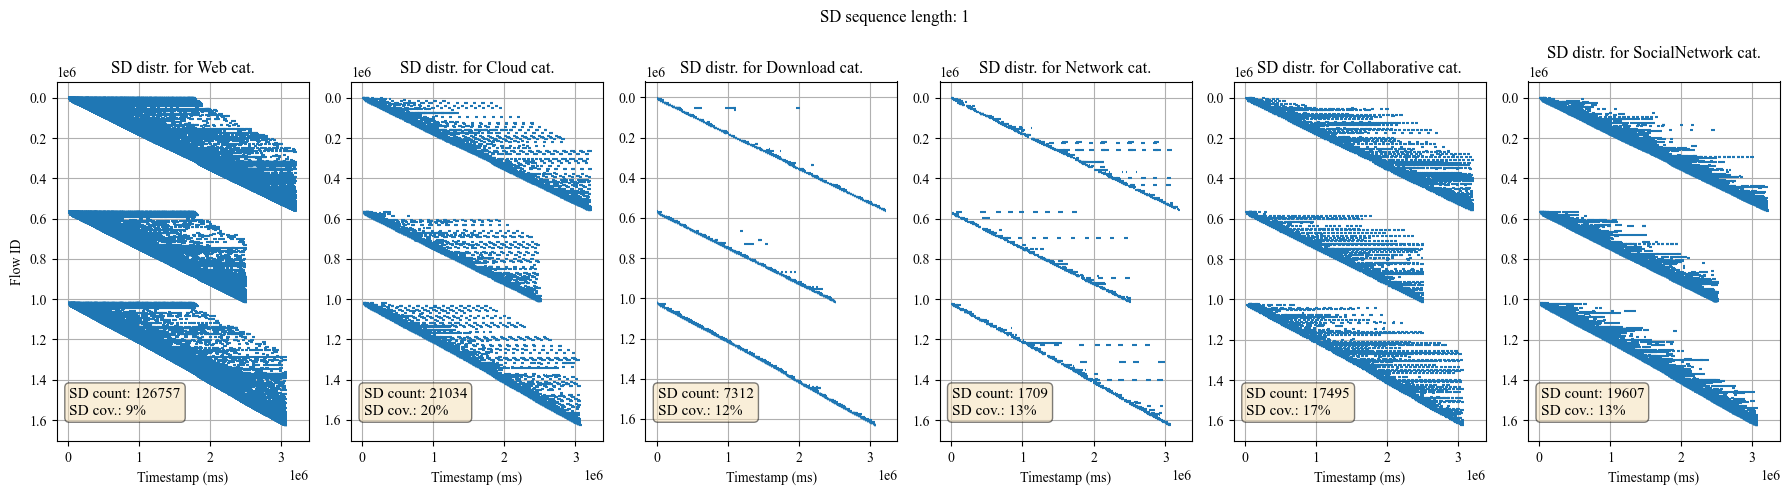

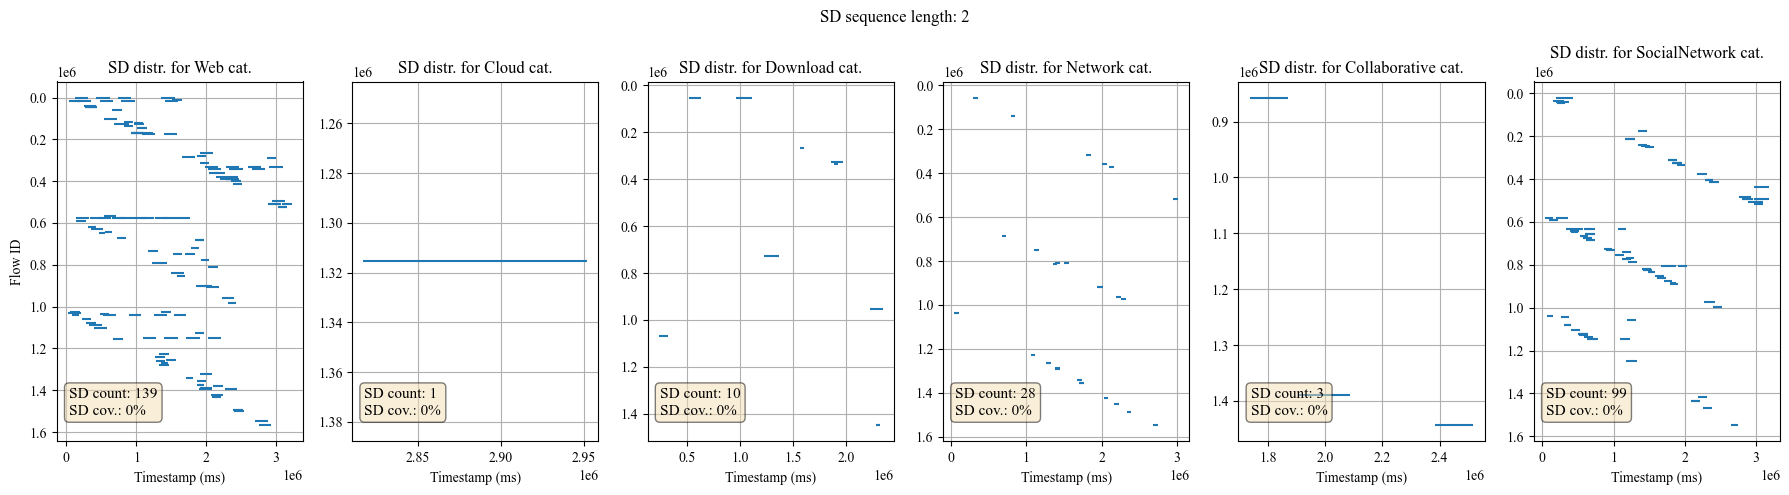

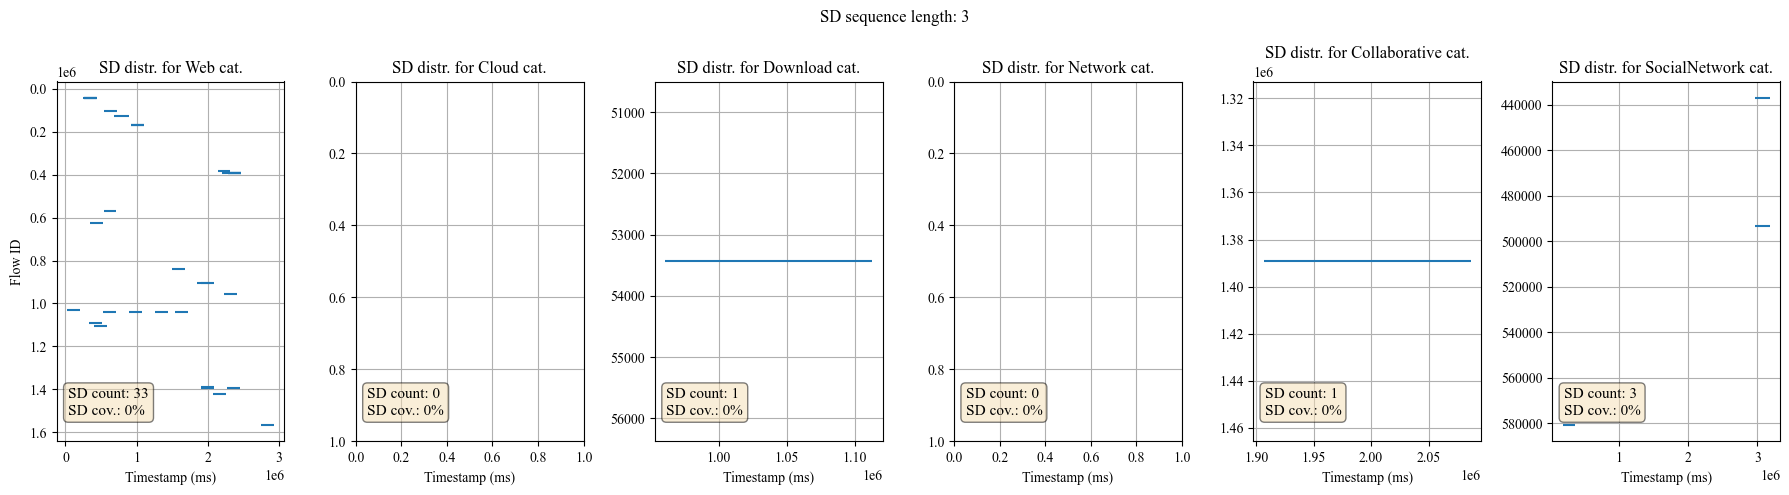

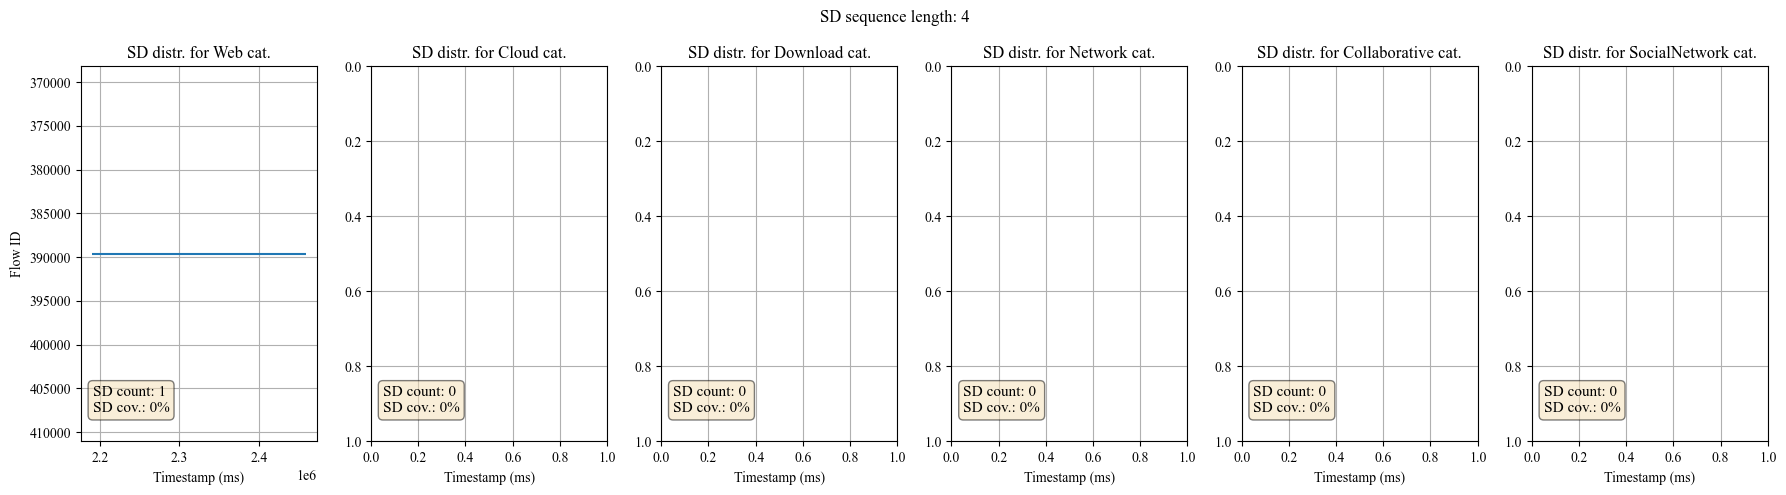

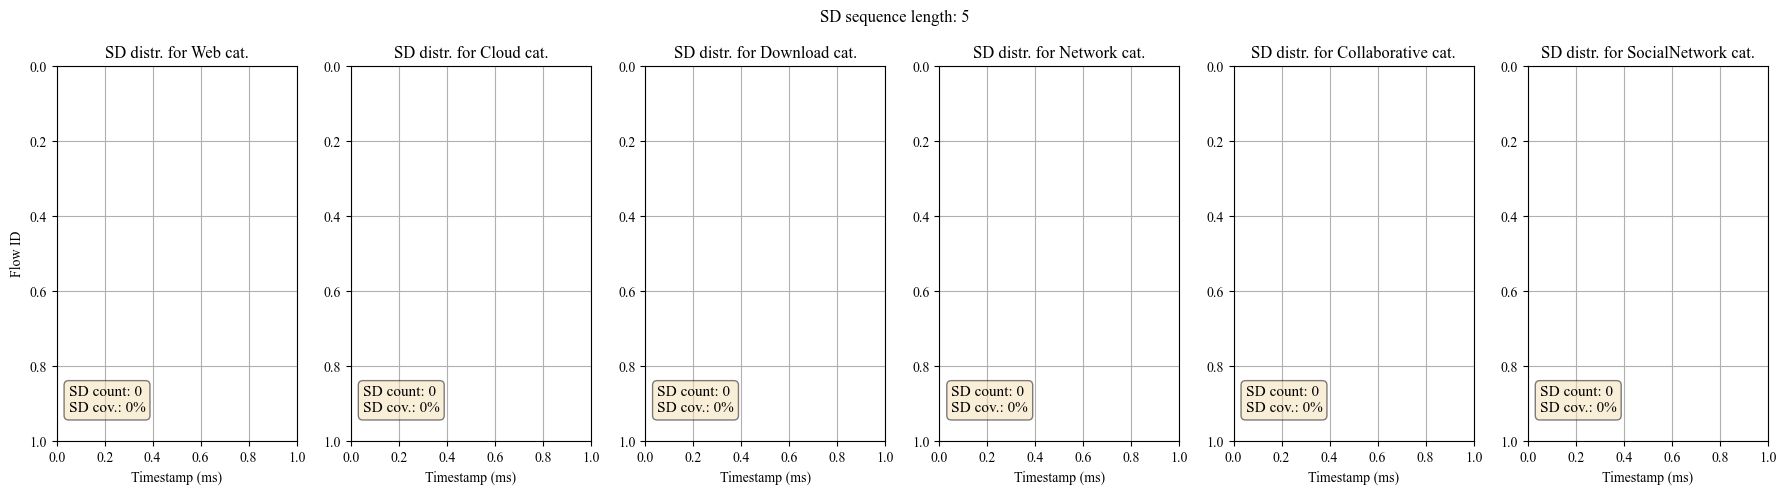

In [35]:
for seq_len in [1, 2, 3, 4, 5]:
    df_train_all[['Z_SD_sequences_idx', 'Z_SD_sequences', 'Z_SD_sequences_timestamps']] = df_train_all.apply(find_SD_sequences, axis=1, delay_SD_col_name='SDd_by_Z',
                                                                                                             jitter_SD_col_name='SDj_by_Z', MIN_SEQ_LEN=seq_len,
                                                                                                             require_jitter_for_sequence=True)
    df_train_all['Z_SD_count'] = df_train_all['Z_SD_sequences_timestamps'].apply(len)
    df_train_all['Z_SD_time'] = df_train_all.apply(lambda row: sum([end - start for (start, end) in row['Z_SD_sequences_timestamps']]), axis=1)

    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(18, 5))
    
    for idx, a in enumerate(ax.flatten()):
        appcat = df_train_all['application_category_name'].unique()[idx]
        subcat_df = df_train_all[df_train_all['application_category_name'] == appcat]
    
        for row_idx, row in subcat_df.iterrows():
            for SDs, SDe in row['Z_SD_sequences_timestamps']:
                a.hlines(y=row_idx, xmin=SDs, xmax=SDe)
    
        a.set_xlabel('Timestamp (ms)')
        if idx == 0:
            a.set_ylabel('Flow ID')
        a.invert_yaxis()
        a.set_title(f'SD distr. for {appcat} cat.')
        a.grid(True)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)                                                   
        text = f"SD count: {sum(subcat_df['Z_SD_count'])}\nSD cov.: {sum(subcat_df['Z_SD_time']) / sum(subcat_df['LAN_time']):.0%}"
        a.text(0.05, 0.15, text, transform=a.transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
    
    plt.suptitle(f"SD sequence length: {seq_len}")
    plt.tight_layout()
    plt.savefig(f'plots/SDanalysis/Z_sequence_analysis_DJ_seq{seq_len}.pdf')
    plt.show()

We see that indeed by `MIN_SEQ_LEN == 4` there are is jutst one SD event marker. In fact at `MIN_SEQ_LEN == 2` and `3` we only see a handful of SD events. The plots for the singular SD events are more popolous but as a result of the lack of longer sequences, they only consist of unique points. This means that requiring both high delay and high jitter SD sequences seems to be a too restrictive requisite for SD events.

---



# Conclusion

For the SD identification threshold, we choose the Z-score method as it takes a potentially more conservative estimate with a lower false positive identification. For the SD event `MIN_SEQ_LEN` we take an empirical approach and choose a unique minimum sequence length for each category that makes the SD coverage rate fall below 10%. With this we aim to reduce the false positive SD events as well. The sequence lengths are also in line with the drastic drops in SD coverage observed during the analysis. Observing this we choose the following minimum sequence length values:

| **Application Category** | `MIN_SEQ_LEN` |
|--------------------------|---------------|
| Web                      | 6             |
| Cloud                    | 3             |
| Download                 | 2             |
| Network                  | 2             |
| Collaborative            | 8             |
| Social Network           | 2       

The following figure shows an example for an SD event for an application category that has a `MIN_SEQ_LEN` 2 as a requirement. An earlier LAN delay would also be an outlier on its own, however lacking a high enough jitter and a subsequent outlier this one does not qualify as a SD event.

![Service Degradation](images/service-degradation.svg) |
-
An example for Service Degradation event for an application category that has a `MIN_SEQ_LEN` 2 as a requirement      |

In [36]:
min_seq_lens = {
    'Download': 2, 'Network': 2, 'SocialNetwork': 2,
    'Web': 6,
    'Cloud': 3,
    'Collaborative': 8
}

In [37]:
# Save the MIN_SEQ_LEN configuration
json_object = json.dumps(min_seq_lens, indent=4)
with open(f"{WD}/min_seq_lens.json", "w") as outfile:
    outfile.write(json_object)

In [38]:
df_train_all[['Z_SD_sequences_idx', 'Z_SD_sequences', 'Z_SD_sequences_timestamps']] = df_train_all.apply(find_SD_sequences, axis=1, delay_SD_col_name='SDd_by_Z',
                                                                                                         jitter_SD_col_name='SDj_by_Z', MIN_SEQ_LEN=min_seq_lens)
df_train_all['Z_SD_count'] = df_train_all['Z_SD_sequences_timestamps'].apply(len)
df_train_all['Z_SD_time'] = df_train_all.apply(lambda row: sum([end - start for (start, end) in row['Z_SD_sequences_timestamps']]), axis=1)

In [39]:
def calculate_SDd_SDj(row, df_mean_std_for_app_cats):
    import pandas as pd
    delay_mean = df_mean_std_for_app_cats[row['application_category_name']].loc['D_mean']
    delay_std = df_mean_std_for_app_cats[row['application_category_name']].loc['D_std']
    jitter_mean = df_mean_std_for_app_cats[row['application_category_name']].loc['J_mean']
    jitter_std = df_mean_std_for_app_cats[row['application_category_name']].loc['J_std']
    SDd = [((x - delay_mean) / delay_std) > 3 for x in row['LAN_delay']]
    SDj = [((x - jitter_mean) / jitter_std) > 3 for x in row['LAN_jitter']]
    return pd.Series([SDd, SDj])

We mark the SD events in all dataframes both in the training dataset and the testing dataset using the information gathered only from the training portion.

In [40]:
for df in tqdm(df_l2s_filtereds):
    df[['SDd', 'SDj']] = df.parallel_apply(calculate_SDd_SDj, df_mean_std_for_app_cats=df_mean_std_for_app_cats, axis=1)
    df[['SD_sequences_idx', 'SD_sequences', 'SD_sequences_timestamps']] = df.parallel_apply(find_SD_sequences, axis=1, delay_SD_col_name='SDd',
                                                                                   jitter_SD_col_name='SDj', MIN_SEQ_LEN=min_seq_lens)
    df['SD_count'] = df['SD_sequences_timestamps'].apply(len)
    df['SD_time'] = df.apply(lambda row: sum([end - start for (start, end) in row['SD_sequences_timestamps']]), axis=1)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\Dev\AppData\Local\Temp\ipykernel_12316\1429809046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['SDd', 'SDj']] = df.parallel_apply(calculate_SDd_SDj, df_mean_std_for_app_cats=df_mean_std_for_app_cats, axis=1)
C:\Users\Dev\AppData\Local\Temp\ipykernel_12316\1429809046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['SDd', 'SDj']] = df.parallel_apply(calculate_SDd_S

# SD Event Statistics

In this section we study different statistics of the identified SD events by the chosen Z-score method.

## Coverage Analysis

The figure below aims to compare the individually identified LAN delay points in each application category by the most strict version of the Quartile Analysis (minimum 25 consecutive high LAN delay and jitter) and the chosen Z-score method.

In [41]:
df_exploded_Q = df_train_all[['application_category_name', 'LAN_delay', 'Q_SD_sequences']].explode(['LAN_delay', 'Q_SD_sequences'])
outliers_Q = df_exploded_Q[df_exploded_Q['Q_SD_sequences']]
df_exploded_Z = df_train_all[['application_category_name', 'LAN_delay', 'Z_SD_sequences']].explode(['LAN_delay', 'Z_SD_sequences'])
outliers_Z = df_exploded_Z[df_exploded_Z['Z_SD_sequences']]

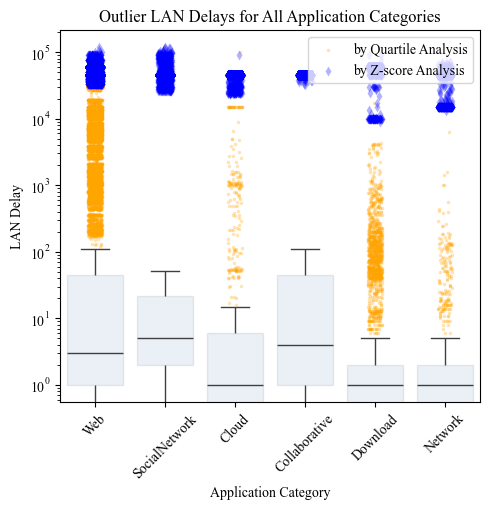

In [42]:
plt.figure(figsize=(5, 5))

sns.stripplot(x='application_category_name', y='LAN_delay', data=outliers_Q, color='orange', jitter=True, marker='.', alpha=0.3, order=total_delays_per_category.index, label='by Quartile Analysis')
sns.stripplot(x='application_category_name', y='LAN_delay', data=outliers_Z, color='blue', jitter=True, marker='d', alpha=0.3, order=total_delays_per_category.index, label='by Z-score Analysis')

ax = sns.boxplot(x='application_category_name',
                 y='LAN_delay', data=df_exploded_Q,
                 order=total_delays_per_category.index,
                 boxprops=dict(alpha=.1),
                showfliers=False)

plt.xticks(rotation=45)
plt.ylabel('LAN Delay')
plt.xlabel('Application Category')
plt.yscale('log')
legend_without_duplicate_labels(ax, loc='upper right')
plt.tight_layout()
plt.savefig('plots/SDanalysis/delays_marked_as_SD.pdf')
plt.savefig('plots/SDanalysis/delays_marked_as_SD.png', dpi=500)
plt.title('Outlier LAN Delays for All Application Categories')
plt.show()

This figure is a reiteration of the delay distribution figure we saw earlier. Apart from the boxplots and mean markers present for each application category the SD events marked by the quartile analysis are represented by orange dots, while the blue diamonds are cases the Z-score analysis classified as an anomaly. The vertical axis represents LAN delay, plotted on a logarithmic scale. More extreme LAN delays are towards the top of the figure.

We see that even like this the Quartile Analysis still marks many comparatively small delays as part of long SD events, whereas the Z-score Analyis only chooses more extreme values by default.

## Distribution of number of SD events accross flows

In [43]:
Z_SDs = df_train_all['Z_SD_count']
print(df_train_all['Z_SD_count'].describe())
print(f'Flows with SD events: {len(Z_SDs[Z_SDs > 0])}')

count    1.633027e+06
mean     1.020008e-02
std      1.109906e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.400000e+01
Name: Z_SD_count, dtype: float64
Flows with SD events: 15388


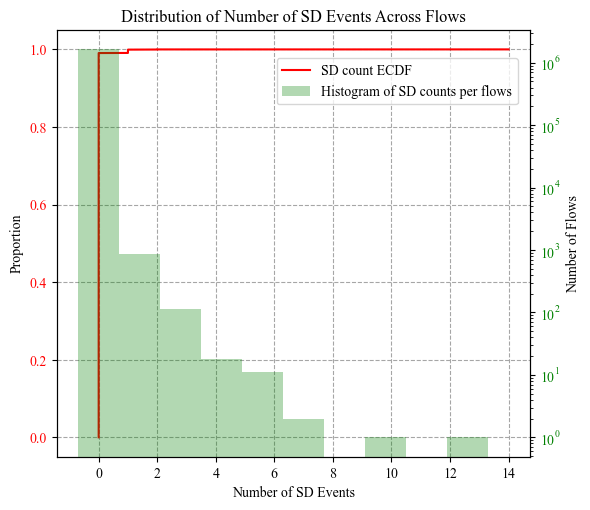

In [44]:
# Visualizing the distribution of SD events across the flows
fig, ax1 = plt.subplots(figsize=(6, 5))
sd_ecdf = ECDF(Z_SDs)
ax1.plot(sd_ecdf.x, sd_ecdf.y, color='red', ls='-', label="SD count ECDF")
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True, which="both", ls="--", c='0.65')
ax1.set_xlabel('Number of SD Events')
ax1.set_ylabel('Proportion')

ax2 = ax1.twinx()
ax2.hist(Z_SDs, color='green', alpha=0.3, align='left', label="Histogram of SD counts per flows")
ax2.set_ylabel('Number of Flows')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_yscale('log')

fig.legend(loc="upper left", bbox_to_anchor=(0.45, 0.95), bbox_transform=ax1.transAxes)
fig.tight_layout()
plt.savefig('plots/SDanalysis/SD_event_count_in_flows.pdf')
ax1.set_title('Distribution of Number of SD Events Across Flows')
plt.show()

The figure displays the "Distribution of Number of SD Events Across Flows." On the Y-axis, which is represented on a logarithmic scale, we see the number of flows. The X-axis represents the number of SD events, ranging from 0 to over 14.
The figure shows that the majority of the flows have no SD events or only a few of them. The ECDF plot shows that aroun 99% of flows have at most one SD event. Multiple events in a single flo are therefore a very rare occurrence..

## Distribution of SD events across application categories

The table below shows the number of flows, number of SD events, number of flows with at least one SD event and the proportion of flows with SD events compared to all flows for all application categories.

In [45]:
df_Z_SDs = pd.DataFrame()
df_Z_SDs['Z_SD_count'] = df_train_all['Z_SD_count']
df_Z_SDs['application_category_name'] = df_train_all['application_category_name']
category_name_counts = df_train_all['application_category_name'].value_counts()
zscore_sd_event_counts = df_Z_SDs.groupby('application_category_name')['Z_SD_count'].sum()
zscore_flows_with_sd_per_category = df_Z_SDs[df_Z_SDs['Z_SD_count'] > 0]['application_category_name'].value_counts()
zscore_proportion_with_sd = zscore_flows_with_sd_per_category / category_name_counts

In [46]:
category_sd_analysis_df = pd.DataFrame({   
    'Total_SD_Events': zscore_sd_event_counts,
    'Flows_with_SD': zscore_flows_with_sd_per_category,
    'Proportion_with_SD': zscore_proportion_with_sd
}).fillna(0).sort_values(by='Proportion_with_SD', ascending=False)
category_sd_analysis_df

Total_SD_Events  Flows_with_SD  Proportion_with_SD
application_category_name                                                    
Web                                  13404          12450            0.012434
SocialNetwork                         1933           1746            0.008620
Cloud                                  745            653            0.003844
Collaborative                          219            215            0.002925
Network                                240            208            0.002715
Download                               116            116            0.001062

In line with the previous figure only a handful of flows have multiple SD events indicated by the slight increase of *Total_SD_Events* over *Flows_with_SD*. The proportion of flows with SD stays below 1% for all application categories and only marginally exceeds this limit in the case of the *Web* category.

## Distribution of SD events in time

In this section we examine how the SD events are distributed in time taking into consideration all the flows in the training dataset.

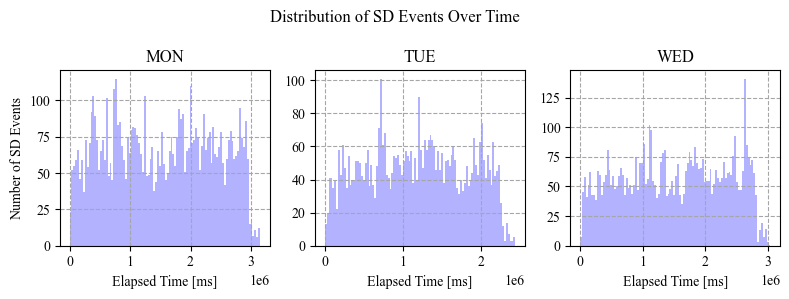

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

for idx, a in enumerate(ax.flatten()):
    df = df_train[idx]
    SD_sequence_starts = df[df['SD_sequences_timestamps'].apply(len) > 0]['SD_sequences_timestamps'].apply(lambda x: [i[0] for i in x])
    SD_sequence_starts = [start_time for flow_subtimes in SD_sequence_starts for start_time in flow_subtimes]
    a.hist(SD_sequence_starts, bins=100, color='blue', alpha=0.3)
    a.set_title(days[idx])
    a.set_xlabel('Elapsed Time [ms]')
    if idx == 0:
        a.set_ylabel('Number of SD Events')
    a.grid(True, which="both", ls="--", c='0.65')
fig.tight_layout()    
plt.savefig('plots/SDanalysis/SD_event_times_distributions.pdf')
fig.suptitle('Distribution of SD Events Over Time')
fig.tight_layout()    
plt.show()

This plot showcases the distribution of SD events in time with the X-axis showing time in milliseconds and the Y-axis portraying the number of SD events occurring around that timestamp. The objective of the plot is to examine whether the SD events are distributed evenly across the flows in time or some spots in time encapsulate more SD events than others.

The figures have a few spikes and valleys indicating that there were a couple of minutes (each bin indicates about half a minute) where the SD count was significantly higher or lower than at other times. On Monday there were more instances of this but the highest SD event activity occurred on Wednesday shortly before the end of the measurement. This may indicate a point in time where SD may have influenced more of the network appearing across multiple flows.

Another descriptive feature on all three days is that towards the end of the measurement window the SD count drastically decreased. This may be due to a characteristic of the timeframe during which the measurement was carried out or may be an influence on the system by the measurement itself, for instance by cutting ongoing flows in half.

---

### Save Results for Location 2

In further analysis we aim to focus only on data from Location 2, therefore we save these flows separately.

In [48]:
path = os.path.join(WD, "preprocessed")

try:
    os.mkdir(path)
except OSError as error:
    print(error)
finally: 
    for day, df in zip(days, df_l2s_filtereds):
        df.to_parquet(f'{path}/{day}v3.parquet', index=False)

[WinError 183] Cannot create a file when that file already exists: 'E:/data\\preprocessed'


---

# Performing the Analysis for the Other Locations

Keeping in mind the conclusions we have drawn with the analysis on *Location 2* we perform the Z-score Analysis SD identification on *Location 1* and *Location 3* as well. This is done in order to shed light on the characteristics of delays and SD events across different locations. To maintain comparability we focus on the same application categories as used in our analysis on data from *Location 2*.

In [49]:
df_l1s = []
for df in tqdm(dfs):
    df_l1 = df[df['location'].str.startswith('1')]
    df_l1s.append(df_l1)
df_l1_train_all = pd.concat(df_l1s[:3])

df_l2_train_all = pd.concat(df_l2s[:3])

df_l3s = []
for df in tqdm(dfs):
    df_l3 = df[df['location'].str.startswith('3')]
    df_l3s.append(df_l3)
df_l3_train_all = pd.concat(df_l3s[:3])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.15s/it]


### Flow Count Characteristics

In [50]:
# Check the cardinality of the application categories
category_name_counts_1 = df_l1_train_all['application_category_name'].value_counts()
category_name_counts_2 = df_l2_train_all['application_category_name'].value_counts()
category_name_counts_3 = df_l3_train_all['application_category_name'].value_counts()

In [51]:
app_cats_to_show = ['Web', 'SocialNetwork', 'Cloud', 'Network', 'Download', 'Collaborative', 'Advertisement']
category_name_counts_all = pd.concat([cnc.loc[app_cats_to_show] for cnc in [category_name_counts_1, category_name_counts_2, category_name_counts_3]], axis=1)
category_name_counts_all.columns = ['Location 1', 'Location 2', 'Location 3']

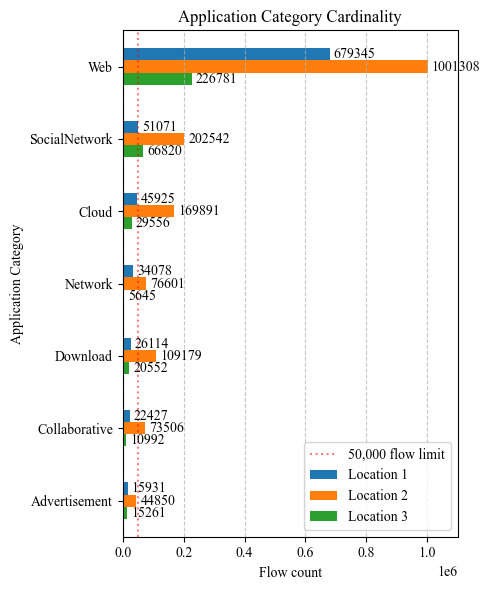

In [52]:
# Visualize the total number of LAN delays for each application category
ax = category_name_counts_all.plot(kind='barh', figsize=(5, 6))
plt.axvline(x = 50_000, color = 'r', linestyle=':', label = '50,000 flow limit', alpha=0.5)
# Adding numerical labels next to each bar
for p in ax.patches:  # ax.patches contains the list of bars
    ax.annotate(str(p.get_width()),  # Use the bar's width (value) as label
                (p.get_width(), p.get_y() + p.get_height() / 2),  # Position at the end of the bar
                xytext=(3, 0),  # 3 points horizontal offset
                textcoords='offset points',  # Offset (5, 0) from the end of the bar
                va='center',  # Center the label vertically with respect to the bar
                ha='left')    # Align the text to the left
plt.xlim(0, 1_100_000)
plt.xlabel('Flow count')
plt.ylabel('Application Category')
plt.gca().invert_yaxis()  # Invert y-axis to have categories with the highest counts at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('plots/SDanalysis/trainset_app_cat_cardinality_all_locs.pdf')
plt.title('Application Category Cardinality')
plt.tight_layout()
plt.show()

We observe that the 50,000 flow count limit per category we set in the original analyis is only fulfilled by the *Web* and *Social Network* application categories for both *Location 1* and  *3*. A lower flow count may tip the SD event characteristics in favor of the behavior of a fewer flow records that may not be as representative as data gathered from a higher flow count. Despite this we continue with all previously chosen *Web*, *Social Network*, *Cloud*, *Network*, *Download* and *Collaborative* application categories keeping note of the fact that the results may not be as reliable for application categories with lower sample count. Analyzing the difference in results between the SD event requirements achieved by categories with a lower flow count and the difference of the same metric with a high flow count categories we may be able quantify whether the 50,000 flow arbitrary limit is reasonable or could be lowered.

In [53]:
df_l2_train_all = df_train_all

df_l1_filtereds = []
for df in tqdm(df_l1s):
    df_l1_filtereds.append(df[df['application_category_name'].isin(['Web', 'SocialNetwork', 'Cloud', 'Network', 'Download', 'Collaborative'])])
df_l1_train_all = pd.concat(df_l1_filtereds[:3]).reset_index(drop=True)
df_l1_train_all.index.name = 'index'

df_l3_filtereds = []
for df in tqdm(df_l3s):
    df_l3_filtereds.append(df[df['application_category_name'].isin(['Web', 'SocialNetwork', 'Cloud', 'Network', 'Download', 'Collaborative'])])
df_l3_train_all = pd.concat(df_l3_filtereds[:3]).reset_index(drop=True)
df_l3_train_all.index.name = 'index'

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.58it/s]


### Delay Characteristics
#### Delay Count

In [54]:
# Calculate the total number of LAN delays for each application category
total_delays_per_category_1 = df_l1_train_all.groupby('application_category_name').apply(lambda x: x['LAN_delay'].apply(len).sum()).sort_values(ascending=False)
total_delays_per_category_2 = df_l2_train_all.groupby('application_category_name').apply(lambda x: x['LAN_delay'].apply(len).sum()).sort_values(ascending=False)
total_delays_per_category_3 = df_l3_train_all.groupby('application_category_name').apply(lambda x: x['LAN_delay'].apply(len).sum()).sort_values(ascending=False)

total_delays_per_category_all = pd.concat([total_delays_per_category_1, total_delays_per_category_2, total_delays_per_category_3], axis=1)
total_delays_per_category_all.columns = ['Location 1', 'Location 2', 'Location 3']

In [55]:
total_delays_per_category_all

Location 1  Location 2  Location 3
application_category_name                                    
Web                           3453780     9016470     2017416
SocialNetwork                  490886     1797216      555845
Cloud                          330038     1177916      197503
Collaborative                  256976      743453      109425
Download                       143806      440421      110501
Network                        109343      264156       38057

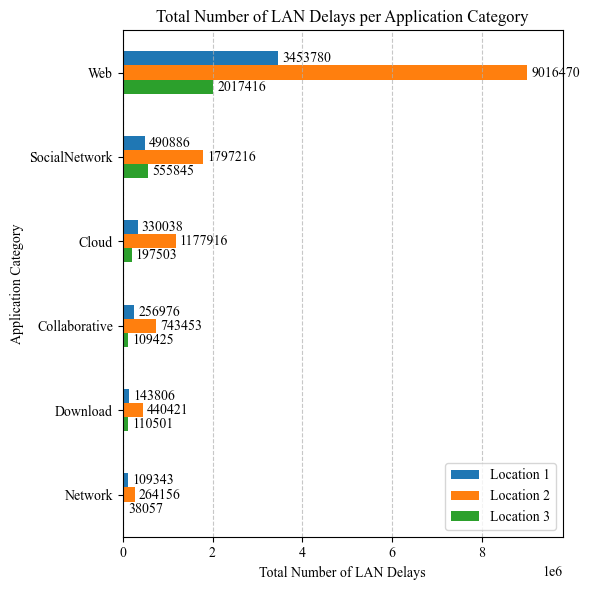

In [56]:
# Visualize the total number of LAN delays for each application category
ax = total_delays_per_category_all.plot(kind='barh', figsize=(6, 6))
# Adding numerical labels next to each bar
for p in ax.patches:  # ax.patches contains the list of bars
    if p.get_width() != 0:
        ax.annotate(str(p.get_width()),  # Use the bar's width (value) as label
                    (p.get_width(), p.get_y() + p.get_height() / 2),  # Position at the end of the bar
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords='offset points',  # Offset (5, 0) from the end of the bar
                    va='center',  # Center the label vertically with respect to the bar
                    ha='left')    # Align the text to the left
plt.xlim(0, 9_800_000)
plt.xlabel('Total Number of LAN Delays')
plt.ylabel('Application Category')
plt.gca().invert_yaxis()  # Invert y-axis to have categories with the highest counts at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/SDanalysis/delay_trainset_app_cat_cardinality_all_locs.pdf')
plt.title('Total Number of LAN Delays per Application Category')
plt.tight_layout()
plt.show()

Plotting the delay count for all application categories we see similar patterns to the flow count statistics with the values falling short of the delay count at *Location 2*, with *Location 3* showing a significantly lower count even compared to *Location 1*.

#### Delay Distributions

In [57]:
# Explode the 'LAN_delay' and 'LAN_jitter' columns to create a row for each delay
df_exploded_delay_l1 = df_l1_train_all[['application_category_name', 'LAN_delay']].explode('LAN_delay').reset_index()
df_exploded_jitter_l1 = df_l1_train_all[['application_category_name', 'LAN_jitter']].explode('LAN_jitter').reset_index()
# Uniting the two metrics into a single DataFrame
df_exploded_delay_l1.columns = df_exploded_delay_l1.columns.to_list()[:-1] + ["Delay / Jitter [ms]"]
df_exploded_delay_l1['Metric'] = "Delay"
df_exploded_jitter_l1.columns = df_exploded_jitter_l1.columns.to_list()[:-1] + ["Delay / Jitter [ms]"]
df_exploded_jitter_l1['Metric'] = "Jitter"
df_exploded_l1 = pd.concat([df_exploded_delay_l1, df_exploded_jitter_l1])
df_exploded_l1 = df_exploded_l1.astype({'Delay / Jitter [ms]': 'int64'})

# Explode the 'LAN_delay' and 'LAN_jitter' columns to create a row for each delay
df_exploded_delay_l3 = df_l3_train_all[['application_category_name', 'LAN_delay']].explode('LAN_delay').reset_index()
df_exploded_jitter_l3 = df_l3_train_all[['application_category_name', 'LAN_jitter']].explode('LAN_jitter').reset_index()
# Uniting the two metrics into a single DataFrame
df_exploded_delay_l3.columns = df_exploded_delay_l3.columns.to_list()[:-1] + ["Delay / Jitter [ms]"]
df_exploded_delay_l3['Metric'] = "Delay"
df_exploded_jitter_l3.columns = df_exploded_jitter_l3.columns.to_list()[:-1] + ["Delay / Jitter [ms]"]
df_exploded_jitter_l3['Metric'] = "Jitter"
df_exploded_l3 = pd.concat([df_exploded_delay_l3, df_exploded_jitter_l3])
df_exploded_l3 = df_exploded_l3.astype({'Delay / Jitter [ms]': 'int64'})

C:\Users\Dev\AppData\Local\Temp\ipykernel_12316\3401181846.py:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


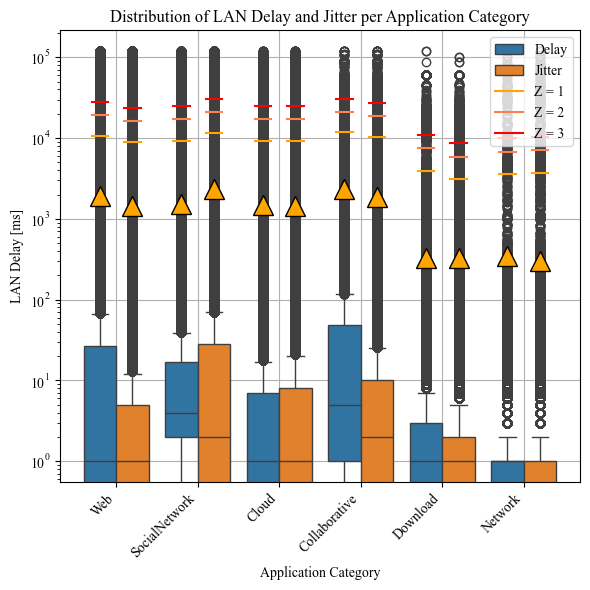

In [58]:
# Visualize the distribution of metrics for each category using boxplots on Location 1
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x='application_category_name',
                 y='Delay / Jitter [ms]',
                 hue='Metric',
                 data=df_exploded_l1,
                 order=total_delays_per_category_1.index,
                 showmeans=True,
                 meanprops={"marker":"^",
                             "markerfacecolor":"orange", 
                             "markeredgecolor":"black",
                             "markersize":"15"})
 
# Calculate mean and standard deviation for each group/hue combination
grouped = df_exploded_l1.groupby(['application_category_name', 'Metric'])
means_stds = grouped['Delay / Jitter [ms]'].agg(['mean', 'std'])
# Calculate mean + 3*standard_deviation
means_stds['mean_plus_1std'] = means_stds['mean'] + 1 * means_stds['std']
means_stds['mean_plus_2std'] = means_stds['mean'] + 2 * means_stds['std']
means_stds['mean_plus_3std'] = means_stds['mean'] + 3 * means_stds['std']
# Get unique hues for plotting
hues = df_exploded_l1['Metric'].unique()
# Plot mean + 3*standard_deviation
for position, group in enumerate(total_delays_per_category_2.index):
    for hue in hues:
        # Find the position of the boxplot
        start = position - 0.3 if hue == 'Delay' else position + 0.1
        end = position - 0.1 if hue == 'Delay' else position + 0.3
        # Get mean + 3*std value
        mean_plus_1std = means_stds.loc[(group, hue), 'mean_plus_1std']
        mean_plus_2std = means_stds.loc[(group, hue), 'mean_plus_2std']
        mean_plus_3std = means_stds.loc[(group, hue), 'mean_plus_3std']
        # Draw a line for the Z-scores 1, 2 and 3
        ax.plot([start, end], [mean_plus_1std, mean_plus_1std], color='orange', label='Z = 1')
        ax.plot([start, end], [mean_plus_2std, mean_plus_2std], color='coral', label='Z = 2')
        ax.plot([start, end], [mean_plus_3std, mean_plus_3std], color='red', label='Z = 3')

plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel('LAN Delay [ms]')
plt.xlabel('Application Category')
plt.tight_layout()
plt.grid()
legend_without_duplicate_labels(ax, loc='upper right')
plt.tight_layout()
plt.savefig('plots/SDanalysis/Z_score_analysis_loc1.pdf')
plt.savefig('plots/SDanalysis/Z_score_analysis_loc1.png', dpi=500)
plt.title('Distribution of LAN Delay and Jitter per Application Category')
plt.tight_layout()
plt.show()

The delay and jitter distributions show virtually identical patterns as the distribution plotted at Location 2. The same relative delays among the application categories, similar gaps between the boxes and means, as between means and Z-score limits, and comparable boxes can be observed. The only apparent differences are in that Web delays strech down below 1 ms at *Location 1* and that the 75th percentile of Network delays stay below 1 ms with only outliers reaching over a few milliseconds. This portrays that a lower flow count may results in a slight bias for lower delays, however, we do not lose the essence of delay distribution characteristics using under half the flow and delay count.

C:\Users\Dev\AppData\Local\Temp\ipykernel_12316\916995081.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


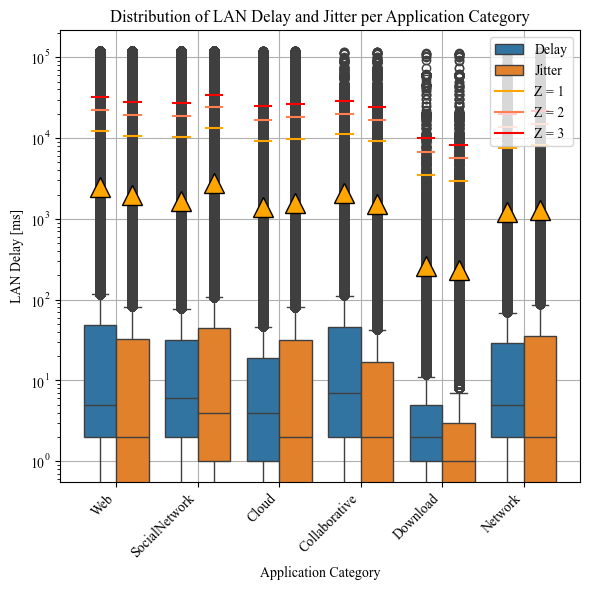

In [59]:
# Visualize the distribution of metrics for each category using boxplots on Location 3
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x='application_category_name',
                 y='Delay / Jitter [ms]',
                 hue='Metric',
                 data=df_exploded_l3,
                 order=total_delays_per_category_1.index,
                 showmeans=True,
                 meanprops={"marker":"^",
                             "markerfacecolor":"orange", 
                             "markeredgecolor":"black",
                             "markersize":"15"})

for i, patch in enumerate(ax.artists):  
    if i >= boxes_per_group * 2:  # Skip the first two categories (each has boxes_per_group boxes)
        patch.set_alpha(0.3)

# Calculate mean and standard deviation for each group/hue combination
grouped = df_exploded_l3.groupby(['application_category_name', 'Metric'])
means_stds = grouped['Delay / Jitter [ms]'].agg(['mean', 'std'])
# Calculate mean + 3*standard_deviation
means_stds['mean_plus_1std'] = means_stds['mean'] + 1 * means_stds['std']
means_stds['mean_plus_2std'] = means_stds['mean'] + 2 * means_stds['std']
means_stds['mean_plus_3std'] = means_stds['mean'] + 3 * means_stds['std']
# Get unique hues for plotting
hues = df_exploded_l3['Metric'].unique()
# Plot mean + 3*standard_deviation
for position, group in enumerate(total_delays_per_category_2.index):
    for hue in hues:
        # Find the position of the boxplot
        start = position - 0.3 if hue == 'Delay' else position + 0.1
        end = position - 0.1 if hue == 'Delay' else position + 0.3
        # Get mean + 3*std value
        mean_plus_1std = means_stds.loc[(group, hue), 'mean_plus_1std']
        mean_plus_2std = means_stds.loc[(group, hue), 'mean_plus_2std']
        mean_plus_3std = means_stds.loc[(group, hue), 'mean_plus_3std']
        # Draw a line for the Z-scores 1, 2 and 3
        ax.plot([start, end], [mean_plus_1std, mean_plus_1std], color='orange', label='Z = 1')
        ax.plot([start, end], [mean_plus_2std, mean_plus_2std], color='coral', label='Z = 2')
        ax.plot([start, end], [mean_plus_3std, mean_plus_3std], color='red', label='Z = 3')

plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel('LAN Delay [ms]')
plt.xlabel('Application Category')
plt.tight_layout()
plt.grid()
legend_without_duplicate_labels(ax, loc='upper right')
plt.tight_layout()
plt.savefig('plots/SDanalysis/Z_score_analysis_loc3.pdf')
plt.savefig('plots/SDanalysis/Z_score_analysis_loc3.png', dpi=500)
plt.title('Distribution of LAN Delay and Jitter per Application Category')
plt.tight_layout()
plt.show()

*Location 3* had an even lower number of delays it could rely on. In line with this, the delay and jitter distributions observe greater differences. At this location traffic from all categories had higher delay values overall with the 25th percentile values stepping up a few milliseconds resulting in a wider distribution in jitter as well. However, these may be due to different network traffic characteristics overall as there is a consistant increase for all categories which could better be described by the higher latency as a result of the eccentric location of *Location 3* compared to the other locations which are in the same municipality. 

The overall patterns, i.e. the higher percentiles, mean values and Z-scores also show similar characteristics.

In [60]:
df_mean_std_for_app_cats_l1l3 = []
df_z_scores_delays_l1l3 = []
df_z_scores_jitter_l1l3 = []

for df in [df_l1_train_all, df_l3_train_all]:
    df_z_scores_delays = pd.DataFrame()
    df_z_scores_jitter = pd.DataFrame()
    df_mean_std_for_app_cats = pd.DataFrame(index=['D_mean', 'D_std', 'J_mean', 'J_std'])
    
    for app_cat in df['application_category_name'].unique():
        group_delays = df[df['application_category_name'] == app_cat]['LAN_delay'].explode()
        group_jitter = df[df['application_category_name'] == app_cat]['LAN_jitter'].explode()
        
        # Compute Z-scores for each delay value
        delay_mean = np.mean(group_delays.to_list())
        delay_std = np.std(group_delays.to_list())
        jitter_mean = np.mean(group_jitter.to_list())
        jitter_std = np.std(group_jitter.to_list())
        df_mean_std_for_app_cats[app_cat] = [delay_mean, delay_std, jitter_mean, jitter_std]
        group_delay_z_scores = [(x - delay_mean) / delay_std  for x in group_delays.to_list()]
        group_jitter_z_scores = [(x - jitter_mean) / jitter_std for x in group_jitter.to_list()]
    
        df_group_delays = pd.DataFrame(group_delays).reset_index()
        df_group_jitter = pd.DataFrame(group_jitter).reset_index()
        df_group_delays['z_scores'] = group_delay_z_scores
        df_group_jitter['z_scores'] = group_jitter_z_scores
        df_z_scores_delays = pd.concat([df_z_scores_delays, df_group_delays])
        df_z_scores_jitter = pd.concat([df_z_scores_jitter, df_group_jitter])

    df_mean_std_for_app_cats_l1l3.append(df_mean_std_for_app_cats)
    df_z_scores_delays_l1l3.append(df_z_scores_delays)
    df_z_scores_jitter_l1l3.append(df_z_scores_jitter)

In [61]:
df_mean_std_for_app_cats_l1l3[0]

Web     Download      Network        Cloud  SocialNetwork  \
D_mean  1945.084081   329.438215   351.339107  1475.122440    1527.174690   
D_std   8761.141789  3551.115957  3205.054976  7836.643694    7785.252682   
J_mean  1432.025250   323.329826   303.341860  1454.340806    2314.184187   
J_std   7430.500684  2764.909493  3382.508811  7767.232601    9335.855700   

        Collaborative  
D_mean    2314.521741  
D_std     9421.932219  
J_mean    1885.772403  
J_std     8353.779919

In [62]:
df_mean_std_for_app_cats_l1l3[1]

Web  SocialNetwork     Download        Cloud      Network  \
D_mean  2495.821383    1684.572370   264.628248  1410.331787  1212.665922   
D_std   9888.790674    8474.791321  3203.270913  7777.247987  6253.597021   
J_mean  1969.486243    2739.774216   233.125727  1580.083462  1286.546969   
J_std   8673.236777   10574.793732  2683.393826  8197.802367  6879.521811   

        Collaborative  
D_mean    2070.172511  
D_std     9001.136953  
J_mean    1520.296870  
J_std     7572.175791

### Examining SD Events For Prolonged High Delay Scenarios

To examine longer SD events with more consecutive high delay events we only study the selected scenario from the *Location 2* analysis, namely, at the start of an SD event there should be an outlying delay and jitter in terms of Z-score ($Z>3$) with the high delay continuing throughout the event. We study the number and coverage percentage of such delay events increasing the minimum sequence length required for an SD event at every step. This time we omit to plot the results and only show the aforementioned metrics in tables.

In [63]:
for df, df_z_scores_delays, df_z_scores_jitter in zip([df_l1_train_all, df_l3_train_all], df_z_scores_delays_l1l3, df_z_scores_jitter_l1l3):
    df_z_scores_delays = df_z_scores_delays.reset_index()
    df_z_scores_jitter = df_z_scores_jitter.reset_index()
    df_z_scores_delays.sort_values(['index', 'level_0'], inplace=True) # sorting first by index (original flow index), than by level_0 order in the flow)
    df_z_scores_jitter.sort_values(['index', 'level_0'], inplace=True)
    df_z_scores_delays['SD_by_Z'] = df_z_scores_delays['z_scores'].apply(lambda x: True if x > 3 else False)
    df_z_scores_jitter['SD_by_Z'] = df_z_scores_jitter['z_scores'].apply(lambda x: True if x > 3 else False)
    
    df['SDd_by_Z'] = df_z_scores_delays.groupby('index').agg({'SD_by_Z': lambda x: x.tolist()})
    df['SDj_by_Z'] = df_z_scores_jitter.groupby('index').agg({'SD_by_Z': lambda x: x.tolist()})

In [64]:
for idx, df in enumerate([df_l1_train_all, df_l3_train_all]):
    SD_count = pd.DataFrame(index=list(df['application_category_name'].unique()))
    SD_coverage = pd.DataFrame(index=list(df['application_category_name'].unique()))
    for seq_len in tqdm(range(1, 11)):
        df[['Z_SD_sequences_idx', 'Z_SD_sequences', 'Z_SD_sequences_timestamps']] = df.parallel_apply(find_SD_sequences,
                                                                                                      axis=1,
                                                                                                      delay_SD_col_name='SDd_by_Z',
                                                                                                      jitter_SD_col_name='SDj_by_Z',
                                                                                                      MIN_SEQ_LEN=seq_len)
        df['Z_SD_count'] = df['Z_SD_sequences_timestamps'].apply(len)
        df['Z_SD_time'] = df.apply(lambda row: sum([end - start for (start, end) in row['Z_SD_sequences_timestamps']]), axis=1)

        SD_counts = []
        SD_covs = []
        for appcat in df['application_category_name'].unique():
            subcat_df = df[df['application_category_name'] == appcat]
            SD_counts.append(sum(subcat_df['Z_SD_count']))
            SD_covs.append(f"{sum(subcat_df['Z_SD_time']) / sum(subcat_df['LAN_time']):.0%}")
        SD_count[seq_len] = SD_counts
        SD_coverage[seq_len] = SD_covs

    print(f'Location {idx+idx+1}')
    print(SD_count)
    print(SD_coverage)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [20:00<00:00, 120.07s/it]


Location 1
                  1      2      3      4     5     6     7     8     9     10
Web            43057  16366  12642  10893  8619  4213  3274  1974  1707  1577
Download         856     35     24     19    18    17    17    17    17    17
Network          405     35     30     28    25    10     9     4     3     3
Cloud           6602   1901    218    176   115    77    58    44    43    41
SocialNetwork   5272    611    467    384   344   220   143   131   124   109
Collaborative   6017   1761    671    614   571   517   474    66    50    50
                1    2    3    4    5    6    7   8   9   10
Web            24%  18%  17%  16%  14%   9%   8%  6%  5%  5%
Download       15%   8%   7%   7%   7%   7%   7%  7%  7%  7%
Network        16%   6%   6%   6%   5%   3%   3%  1%  1%  1%
Cloud          27%  13%   4%   3%   3%   2%   2%  2%  2%  2%
SocialNetwork  18%   6%   6%   5%   5%   4%   3%  3%  3%  2%
Collaborative  32%  19%  13%  13%  12%  11%  11%  2%  2%  2%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:17<00:00, 49.73s/it]

Location 3
                  1      2     3     4     5     6     7     8     9     10
Web            27154  10213  8005  7072  5667  2804  2202  1374  1164  1037
SocialNetwork   6293    501   376   313   266   201   132   124   120   117
Download         825     30    15    11    10     9     9     8     8     8
Cloud           3774    894   113    90    62    41    38    36    35    33
Network          529     68    60    51    37     7     6     5     1     1
Collaborative   1960    695   382   329   309   278   246    58    46    43
                1    2    3    4    5    6    7   8   9   10
Web            24%  17%  16%  15%  13%   9%   8%  6%  5%  5%
SocialNetwork  19%   5%   4%   4%   4%   3%   2%  2%  2%  2%
Download       14%   7%   6%   5%   5%   5%   5%  5%  5%  5%
Cloud          25%  11%   3%   3%   3%   2%   2%  2%  2%  2%
Network        21%   9%   9%   8%   6%   2%   2%  1%  0%  0%
Collaborative  32%  23%  19%  18%  17%  16%  15%  5%  5%  5%


The SD event counts are gravely reduced however, we see that the coverage percentages show a highly similar decaying pattern with only a few percentage point differences. Adding to this when we look for the same patterns, i.e. when does the threshold fall below 10% and when is there a significant drop in coverage we see the exact same limit numbers as we saw earlier. These are the following:

| **Application Category** | `MIN_SEQ_LEN` |
|--------------------------|---------------|
| Web                      | 6             |
| Cloud                    | 3             |
| Download                 | 2             |
| Network                  | 2             |
| Collaborative            | 8             |
| Social Network           | 2             |

Not only does this demonstrate that the extreme traffic patterns leading to SD events are similar or identical accross the three locations it also suggests that the same approach can be used on application categories with much lower flow counts and reassures the correctness of the selected approach.

# Validating the Results with Testing Data

For the SD event analyses so far we only used data from the first three measurement days that were intended as training data. The last two days can be used for testing data if we choose to train models on the flows. This data could also be used to validate our findings in terms of SD event identification, i.e. like with different locations when performing the same analysis we tally the results and quantify the differences. Low numerical differences in thresholds and a small number in terms of `MIN_SEQ_LEN` would yield to the further assurance that the chosen methodolgy is sound and produces consistent results.

In [65]:
df_l1_test_all = pd.concat(df_l1_filtereds[3:]).reset_index(drop=True)
df_l1_test_all.index.name = 'index'
df_l2_test_all = pd.concat(df_l2s_filtereds[3:]).reset_index(drop=True)
df_l2_test_all.index.name = 'index'
df_l3_test_all = pd.concat(df_l3_filtereds[3:]).reset_index(drop=True)
df_l3_test_all.index.name = 'index'

### Delay and Jitter Distributions

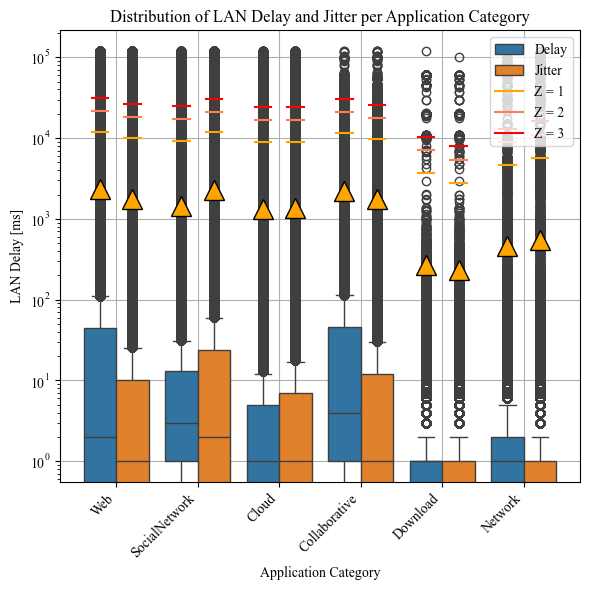

C:\Users\Dev\AppData\Local\Temp\ipykernel_10884\986432198.py:58: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


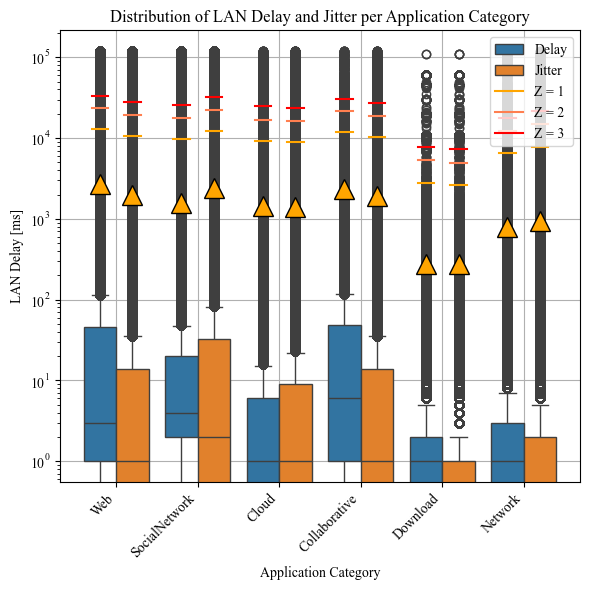

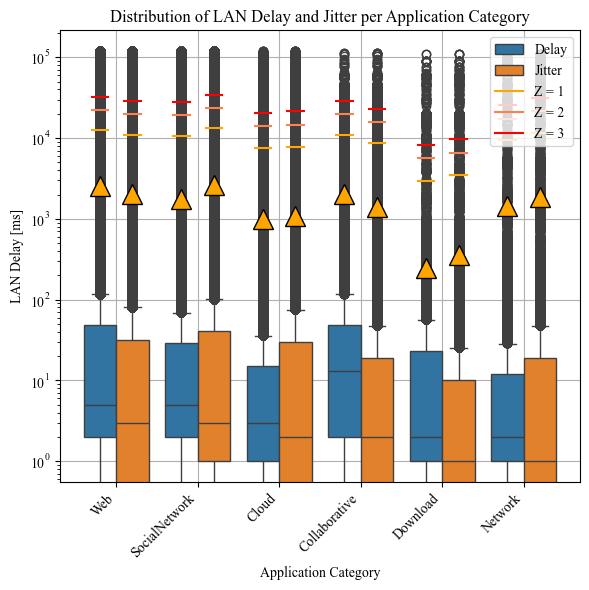

In [66]:
for idx, df_test_all in enumerate([df_l1_test_all, df_l2_test_all, df_l3_test_all]):
    # Calculate the total number of LAN delays for each application category
    total_delays_per_category = df_test_all.groupby('application_category_name').apply(lambda x: x['LAN_delay'].apply(len).sum()).sort_values(ascending=False)
    
    # Explode the 'LAN_delay' and 'LAN_jitter' columns to create a row for each delay
    df_exploded_delay = df_test_all[['application_category_name', 'LAN_delay']].explode('LAN_delay').reset_index()
    df_exploded_jitter = df_test_all[['application_category_name', 'LAN_jitter']].explode('LAN_jitter').reset_index()
    # Uniting the two metrics into a single DataFrame
    df_exploded_delay.columns = df_exploded_delay.columns.to_list()[:-1] + ["Delay / Jitter [ms]"]
    df_exploded_delay['Metric'] = "Delay"
    df_exploded_jitter.columns = df_exploded_jitter.columns.to_list()[:-1] + ["Delay / Jitter [ms]"]
    df_exploded_jitter['Metric'] = "Jitter"
    df_exploded = pd.concat([df_exploded_delay, df_exploded_jitter])
    df_exploded = df_exploded.astype({'Delay / Jitter [ms]': 'int64'})
    
    # Visualize the distribution of metrics for each category using boxplots
    plt.figure(figsize=(6, 6))
    ax = sns.boxplot(x='application_category_name',
                     y='Delay / Jitter [ms]',
                     hue='Metric',
                     data=df_exploded,
                     order=total_delays_per_category.index,
                     showmeans=True,
                     meanprops={"marker":"^",
                                 "markerfacecolor":"orange", 
                                 "markeredgecolor":"black",
                                 "markersize":"15"})
    
    # Calculate mean and standard deviation for each group/hue combination
    grouped = df_exploded.groupby(['application_category_name', 'Metric'])
    means_stds = grouped['Delay / Jitter [ms]'].agg(['mean', 'std'])
    # Calculate mean + 3*standard_deviation
    means_stds['mean_plus_1std'] = means_stds['mean'] + 1 * means_stds['std']
    means_stds['mean_plus_2std'] = means_stds['mean'] + 2 * means_stds['std']
    means_stds['mean_plus_3std'] = means_stds['mean'] + 3 * means_stds['std']
    # Get unique hues for plotting
    hues = df_exploded['Metric'].unique()
    # Plot mean + 3*standard_deviation
    for position, group in enumerate(total_delays_per_category_2.index):
        for hue in hues:
            # Find the position of the boxplot
            start = position - 0.3 if hue == 'Delay' else position + 0.1
            end = position - 0.1 if hue == 'Delay' else position + 0.3
            # Get mean + 3*std value
            mean_plus_1std = means_stds.loc[(group, hue), 'mean_plus_1std']
            mean_plus_2std = means_stds.loc[(group, hue), 'mean_plus_2std']
            mean_plus_3std = means_stds.loc[(group, hue), 'mean_plus_3std']
            # Draw a line for the Z-scores 1, 2 and 3
            ax.plot([start, end], [mean_plus_1std, mean_plus_1std], color='orange', label='Z = 1')
            ax.plot([start, end], [mean_plus_2std, mean_plus_2std], color='coral', label='Z = 2')
            ax.plot([start, end], [mean_plus_3std, mean_plus_3std], color='red', label='Z = 3')
    
    plt.xticks(rotation=45, ha='right')
    plt.yscale('log')
    plt.title('Distribution of LAN Delay and Jitter per Application Category')
    plt.ylabel('LAN Delay [ms]')
    plt.xlabel('Application Category')
    plt.tight_layout()
    plt.grid()
    legend_without_duplicate_labels(ax, loc='upper right')
    plt.tight_layout()
    plt.savefig(f'plots/SDanalysis/Z_score_analysis_test_loc{idx}.pdf')
    plt.show()

When observing the delay and corresponing jitter distributions we see highly similar distributions and identical patterns with slight differences in median values. There are a few more changes between the training and testing distributions for all locations. Namely, *Location 1* has slighly higher *Web* delays with lower jitter. Higher low end in *Social Network* delays and lower *Cloud*, *Download* and *Network* delays with correspondingly lower jitter distribution as well. *Location 2* portrays virtually identical with a wider distribution in *Network* category jitter. *Location 3* retains the same higher distribution observed in the training data due to the geographical distance, it too shows highly similar distributions with the difference being in higher *Download* delays and jitter, this latter presenting itself in mean jitter as well. The other change is a narrower distribution of *Network* delays and jitter however the mean values even increase slighly.

In [67]:
df_mean_std_for_app_cats_test_ls = []
df_z_scores_delays_test_ls = []
df_z_scores_jitter_test_ls = []

for df in [df_l1_test_all, df_l2_test_all, df_l3_test_all]:
    df_z_scores_delays = pd.DataFrame()
    df_z_scores_jitter = pd.DataFrame()
    df_mean_std_for_app_cats = pd.DataFrame(index=['D_mean', 'D_std', 'J_mean', 'J_std'])
    
    for app_cat in df['application_category_name'].unique():
        group_delays = df[df['application_category_name'] == app_cat]['LAN_delay'].explode()
        group_jitter = df[df['application_category_name'] == app_cat]['LAN_jitter'].explode()
        
        # Compute Z-scores for each delay value
        delay_mean = np.mean(group_delays.to_list())
        delay_std = np.std(group_delays.to_list())
        jitter_mean = np.mean(group_jitter.to_list())
        jitter_std = np.std(group_jitter.to_list())
        df_mean_std_for_app_cats[app_cat] = [delay_mean, delay_std, jitter_mean, jitter_std]
        group_delay_z_scores = [(x - delay_mean) / delay_std  for x in group_delays.to_list()]
        group_jitter_z_scores = [(x - jitter_mean) / jitter_std for x in group_jitter.to_list()]
    
        df_group_delays = pd.DataFrame(group_delays).reset_index()
        df_group_jitter = pd.DataFrame(group_jitter).reset_index()
        df_group_delays['z_scores'] = group_delay_z_scores
        df_group_jitter['z_scores'] = group_jitter_z_scores
        df_z_scores_delays = pd.concat([df_z_scores_delays, df_group_delays])
        df_z_scores_jitter = pd.concat([df_z_scores_jitter, df_group_jitter])

    df_mean_std_for_app_cats_test_ls.append(df_mean_std_for_app_cats)
    df_z_scores_delays_test_ls.append(df_z_scores_delays)
    df_z_scores_jitter_test_ls.append(df_z_scores_jitter)

In [68]:
df_mean_std_for_app_cats_test_ls[0]

Web     Download        Cloud  Collaborative  SocialNetwork  \
D_mean  2351.992549   266.347911  1332.539958    2207.310964    1458.644405   
D_std   9585.575586  3389.711196  7595.876942    9300.280033    7779.094851   
J_mean  1779.803561   233.844514  1345.312304    1749.544160    2279.589427   
J_std   8212.082033  2566.586269  7604.645085    8055.490267    9513.975179   

            Network  
D_mean   467.299365  
D_std   4196.794771  
J_mean   542.208260  
J_std   5174.832780

In [69]:
df_mean_std_for_app_cats_test_ls[1]

Web        Cloud  Collaborative     Download      Network  \
D_mean   2717.438827  1437.654019    2321.247928   277.847403   803.569964   
D_std   10264.324690  7725.077085    9498.959939  2506.394251  5673.414920   
J_mean   1963.407565  1387.540174    1908.544591   279.037698   941.612836   
J_std    8599.804037  7472.727870    8456.608974  2314.782551  6886.733665   

        SocialNetwork  
D_mean    1586.092481  
D_std     8111.406291  
J_mean    2434.280300  
J_std     9825.079024

In [70]:
df_mean_std_for_app_cats_test_ls[2]

Web     Download        Cloud  SocialNetwork  Collaborative  \
D_mean   2536.282840   243.046700   994.803984    1745.308454    2035.070462   
D_std   10003.551002  2684.099823  6488.200066    8711.848811    8872.353917   
J_mean   2026.087232   358.021068  1098.976797    2651.006014    1402.941395   
J_std    8880.410337  3110.050025  6761.006993   10560.063811    7257.069670   

            Network  
D_mean  1462.448975  
D_std   7978.062041  
J_mean  1843.799528  
J_std   9759.918891

In [71]:
df_mean_std_for_app_cats_train_ls = [df_mean_std_for_app_cats_l1l3[0], df_mean_std_for_app_cats, df_mean_std_for_app_cats_l1l3[1]]

In [72]:
diff_dfs_abs = []
diff_dfs_rel = []
for df_metrics_train, df_metrics_test in zip(df_mean_std_for_app_cats_train_ls, df_mean_std_for_app_cats_test_ls):
    diff_df_abs = pd.DataFrame(index=['D_mean', 'D_std', 'J_mean', 'J_std'])
    diff_df_rel = pd.DataFrame(index=['D_mean', 'D_std', 'J_mean', 'J_std'])
    for app_cat in df_metrics_train:
        train_data = df_metrics_train[app_cat]
        test_data = df_metrics_test[app_cat]
        diffs_abs = [test - train for train, test in zip(train_data, test_data)]
        diffs_rel = [(test / train) - 1 for train, test in zip(train_data, test_data)]
        diff_df_abs[f'{app_cat}'] = diffs_abs
        diff_df_rel[f'{app_cat}'] = diffs_rel
    diff_dfs_abs.append(diff_df_abs)
    diff_dfs_rel.append(diff_df_rel)

In [73]:
for idx, diff_df in enumerate(diff_dfs_abs):
    print(f'Location {idx+1}')
    print(diff_df)
    print()

Location 1
               Web    Download      Network       Cloud  SocialNetwork  \
D_mean  406.908468  -63.090304   115.960258 -142.582482     -68.530286   
D_std   824.433797 -161.404762   991.739795 -240.766752      -6.157831   
J_mean  347.778312  -89.485312   238.866400 -109.028502     -34.594760   
J_std   781.581349 -198.323224  1792.323970 -162.587516     178.119479   

        Collaborative  
D_mean    -107.210777  
D_std     -121.652186  
J_mean    -136.228243  
J_std     -298.289652  

Location 2
               Web    Download        Cloud  SocialNetwork  Collaborative  \
D_mean  181.155987   34.800703   442.850035    -159.215974     286.177466   
D_std   260.773689 -177.705572  1236.877020    -600.442520     626.606022   
J_mean  -62.679667  -78.983369   288.563377    -216.725713     505.603196   
J_std  -280.606299 -795.267474   711.720876    -734.984786    1199.539304   

            Network  
D_mean  -658.879011  
D_std  -2304.647121  
J_mean  -902.186692  
J_std  -2873

In [74]:
# maxs_D_mean = []
# maxs_D_std = []
# maxs_J_mean = []
# maxs_J_std = []

maxss = []

for idx, diff_df in enumerate(diff_dfs_rel):
    maxs = []
    print(f'Location {idx+1}')
    print(diff_df)
    print()

    for i, row in diff_df.iterrows():
        maxs.append(max([np.abs(x) for x in row]))
    maxss.append(maxs)

Location 1
             Web  Download   Network     Cloud  SocialNetwork  Collaborative
D_mean  0.209198 -0.191509  0.330052 -0.096658      -0.044874      -0.046321
D_std   0.094101 -0.045452  0.309430 -0.030723      -0.000791      -0.012912
J_mean  0.242858 -0.276762  0.787450 -0.074968      -0.014949      -0.072240
J_std   0.105186 -0.071729  0.529880 -0.020932       0.019079      -0.035707

Location 2
             Web  Download     Cloud  SocialNetwork  Collaborative   Network
D_mean  0.071426  0.143185  0.445163      -0.091225       0.140623 -0.450531
D_std   0.026068 -0.066207  0.190635      -0.068923       0.070625 -0.288873
J_mean -0.030936 -0.220611  0.262575      -0.081752       0.360388 -0.489308
J_std  -0.031598 -0.255709  0.105268      -0.069600       0.165293 -0.294386

Location 3
             Web  SocialNetwork  Download     Cloud   Network  Collaborative
D_mean  0.016212       0.036054 -0.081554 -0.294631  0.205978      -0.016956
D_std   0.011605       0.027972 -0.162075

In [75]:
[max([maxs[i] for maxs in maxss]) for i in range(len(maxss[0]))]

[0.4505312816358491,
 0.30942988570353136,
 0.7874495119069265,
 0.5298800595013098]

If we compare the delay and jitter mean and standard deviation statistics we see that there are differences in terms of test and train data, however these do not tend to be high. The highest deviation in delay mean is a 45% decrease in the Network category at Location 2.

### Examining SD Events For Prolonged High Delay Scenarios

In [76]:
for df, df_z_scores_delays, df_z_scores_jitter in zip([df_l1_test_all, df_l2_test_all, df_l3_test_all],
                                                                df_z_scores_delays_test_ls,
                                                                df_z_scores_jitter_test_ls):
    df_z_scores_delays = df_z_scores_delays.reset_index()
    df_z_scores_jitter = df_z_scores_jitter.reset_index()
    df_z_scores_delays.sort_values(['index', 'level_0'], inplace=True) # sorting first by index (original flow index), than by level_0 order in the flow)
    df_z_scores_jitter.sort_values(['index', 'level_0'], inplace=True)
    df_z_scores_delays['SD_by_Z'] = df_z_scores_delays['z_scores'].apply(lambda x: True if x > 3 else False)
    df_z_scores_jitter['SD_by_Z'] = df_z_scores_jitter['z_scores'].apply(lambda x: True if x > 3 else False)
    
    df['SDd_by_Z'] = df_z_scores_delays.groupby('index').agg({'SD_by_Z': lambda x: x.tolist()})
    df['SDj_by_Z'] = df_z_scores_jitter.groupby('index').agg({'SD_by_Z': lambda x: x.tolist()})

In [77]:
for idx, df in enumerate([df_l1_test_all, df_l2_test_all, df_l3_test_all]):
    SD_count = pd.DataFrame(index=list(df['application_category_name'].unique()))
    SD_coverage = pd.DataFrame(index=list(df['application_category_name'].unique()))
    for seq_len in tqdm(range(1, 11)):
        df[['Z_SD_sequences_idx', 'Z_SD_sequences', 'Z_SD_sequences_timestamps']] = df.parallel_apply(find_SD_sequences,
                                                                                                      axis=1,
                                                                                                      delay_SD_col_name='SDd_by_Z',
                                                                                                      jitter_SD_col_name='SDj_by_Z',
                                                                                                      MIN_SEQ_LEN=seq_len)
        df['Z_SD_count'] = df['Z_SD_sequences_timestamps'].apply(len)
        df['Z_SD_time'] = df.apply(lambda row: sum([end - start for (start, end) in row['Z_SD_sequences_timestamps']]), axis=1)

        SD_counts = []
        SD_covs = []
        for appcat in df['application_category_name'].unique():
            subcat_df = df[df['application_category_name'] == appcat]
            SD_counts.append(sum(subcat_df['Z_SD_count']))
            SD_covs.append(f"{sum(subcat_df['Z_SD_time']) / sum(subcat_df['LAN_time']):.0%}")
        SD_count[seq_len] = SD_counts
        SD_coverage[seq_len] = SD_covs

    print(f'Location {idx+1}')
    print(SD_count)
    print(SD_coverage)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:59<00:00, 41.91s/it]


Location 1
                  1     2     3     4     5     6     7     8    9    10
Web            20006  8234  6116  5355  4317  2109  1694  1097  974  888
Download         322    27     8     7     7     7     7     7    7    7
Cloud           3587  1092   139    88    55    32    26    24   24   23
Collaborative   2732   854   381   349   329   299   267    31   23   23
SocialNetwork   3224   321   230   193   167   126   101    95   88   86
Network          288    27    10     9     4     2     2     0    0    0
                1    2    3    4    5    6    7   8   9   10
Web            22%  17%  16%  15%  13%   9%   8%  6%  6%  5%
Download       14%   8%   6%   6%   6%   6%   6%  6%  6%  6%
Cloud          27%  14%   4%   3%   3%   2%   2%  2%  2%  2%
Collaborative  31%  20%  15%  14%  14%  13%  12%  2%  2%  2%
SocialNetwork  18%   6%   5%   5%   4%   4%   3%  3%  3%  3%
Network        18%   4%   2%   2%   1%   1%   1%  0%  0%  0%


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [20:40<00:00, 124.08s/it]


Location 2
                  1      2      3      4      5     6     7     8     9     10
Web            72785  31029  23919  21046  16783  7986  6554  4139  3597  3343
Cloud          11471   3406    494    362    221   137   111   102    96    87
Collaborative   9845   2844   1418   1275   1183  1071  1023   142    84    80
Download        5777     59     32     25     19    13    12    11    11    10
Network         1140    133     88     68     43    12    11     6     1     1
SocialNetwork  11535   1165    848    643    565   401   326   310   303   300
                1    2    3    4    5    6    7   8   9   10
Web            24%  18%  17%  16%  14%   9%   8%  6%  6%  6%
Cloud          28%  14%   5%   4%   3%   3%   2%  2%  2%  2%
Collaborative  33%  21%  16%  15%  14%  13%  13%  2%  2%  2%
Download       19%   3%   3%   3%   2%   2%   2%  2%  2%  2%
Network        20%   7%   5%   5%   3%   1%   1%  1%  0%  0%
SocialNetwork  19%   6%   5%   5%   4%   4%   3%  3%  3%  3%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:26<00:00, 38.61s/it]

Location 3
                  1     2     3     4     5     6     7    8    9    10
Web            19968  7725  6075  5347  4264  1743  1334  780  665  621
Download         564    18     9     6     2     1     1    1    1    1
Cloud           2228   529    88    64    50    25    24   24   21   21
SocialNetwork   4652   574   409   345   258   200   151  137  130  127
Collaborative   1164   412   281   256   239   218   194   33   23   22
Network          217    46    35    30    23     4     4    2    1    1
                1    2    3    4    5    6    7   8   9   10
Web            26%  19%  17%  16%  14%   8%   7%  5%  5%  5%
Download       12%   3%   2%   2%   1%   1%   1%  1%  1%  1%
Cloud          24%  11%   4%   4%   3%   2%   2%  2%  2%  2%
SocialNetwork  21%   7%   6%   6%   5%   4%   4%  3%  3%  3%
Collaborative  35%  26%  23%  22%  22%  20%  19%  5%  5%  4%
Network        18%   8%   7%   6%   5%   1%   1%  1%  0%  0%


In [78]:
for df in tqdm(df_l1_filtereds):
    df[['SDd', 'SDj']] = df.parallel_apply(calculate_SDd_SDj, df_mean_std_for_app_cats=df_mean_std_for_app_cats_l1l3[0], axis=1)
    df[['SD_sequences_idx', 'SD_sequences', 'SD_sequences_timestamps']] = df.parallel_apply(find_SD_sequences, axis=1, delay_SD_col_name='SDd',
                                                                                   jitter_SD_col_name='SDj', MIN_SEQ_LEN=min_seq_lens)
    df['SD_count'] = df['SD_sequences_timestamps'].apply(len)
    df['SD_time'] = df.apply(lambda row: sum([end - start for (start, end) in row['SD_sequences_timestamps']]), axis=1)

for df in tqdm(df_l3_filtereds):
    df[['SDd', 'SDj']] = df.parallel_apply(calculate_SDd_SDj, df_mean_std_for_app_cats=df_mean_std_for_app_cats_l1l3[1], axis=1)
    df[['SD_sequences_idx', 'SD_sequences', 'SD_sequences_timestamps']] = df.parallel_apply(find_SD_sequences, axis=1, delay_SD_col_name='SDd',
                                                                                   jitter_SD_col_name='SDj', MIN_SEQ_LEN=min_seq_lens)
    df['SD_count'] = df['SD_sequences_timestamps'].apply(len)
    df['SD_time'] = df.apply(lambda row: sum([end - start for (start, end) in row['SD_sequences_timestamps']]), axis=1)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\Dev\AppData\Local\Temp\ipykernel_10884\3468016454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['SDd', 'SDj']] = df.parallel_apply(calculate_SDd_SDj, df_mean_std_for_app_cats=df_mean_std_for_app_cats_l1l3[0], axis=1)
C:\Users\Dev\AppData\Local\Temp\ipykernel_10884\3468016454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['SDd', 'SDj']] = df.parallel_apply(calcula

---

In [79]:
path = os.path.join(WD, "SD_added")

try:
    os.mkdir(path)
except OSError as error:
    print(error)
finally: 
    for day, df_l1, df_l2, df_l3 in zip(days, df_l1_filtereds, df_l2s_filtereds, df_l3_filtereds):
        df_SD_added = pd.concat([df_l1, df_l2, df_l3])
        df_SD_added.to_parquet(f'{path}/{day}_of.parquet', index=False)

[WinError 183] Cannot create a file when that file already exists: 'E:/data\\SD_added'


---

The dataset files that contain all the data including
- the columns we dropped during import,
- the flows that were too short to consider for analysis,
- the flows for which there were no LAN delays present and thus were excluded,
- the flows which are not from the selected application categories
- SD event data for all the flows that were selected for analysis

were generated using the following script. For the rows that have undefined columns the `None` value is used.

```python
import pandas as pd
import numpy as np
import sys
import json


def merge_df(DFog, DFnew):
    result_df = pd.merge(DFog, DFnew, on='id', how='outer', suffixes=('_DFog', '_DFnew'))

    # List of original column names without the id column and without duplicates
    original_columns = set(DFog.columns.tolist() + DFnew.columns.tolist()) - {'id'}

    # Iterate through the original columns and resolve conflicts
    for col in original_columns:
        if col in DFog.columns and col in DFnew.columns:  # If the column exists in both DataFrames
            # Fill NaN values from DFnew columns with values from DFog before dropping

            # Detect if the original column in DFnew was of integer type
            is_int = pd.api.types.is_integer_dtype(DFnew[col])
            # Fill NaN values from DF2 columns with values from DF1 before dropping
            filled_values = result_df[col + '_DFnew'].combine_first(result_df[col + '_DFog'])
            # If the original column was int, convert filled values back to nullable int type
            result_df[col] = filled_values.astype(pd.Int64Dtype()) if is_int else filled_values

            # result_df[col] = np.where(result_df[col + '_DFnew'].isnull(), result_df[col + '_DFog'],
            #                           result_df[col + '_DFnew'])
            result_df.drop([col + '_DFog', col + '_DFnew'], axis=1, inplace=True)  # Drop redundant columns
        elif col + '_DFog' in result_df.columns:  # If only DFog has the column
            result_df.rename(columns={col + '_DFog': col}, inplace=True)  # Rename to original
        elif col + '_DFnew' in result_df.columns:  # If only DFnew has the column
            result_df.rename(columns={col + '_DFnew': col}, inplace=True)  # Rename to original

    return result_df


if __name__  == "__main__":
    '''
    Merge multiple dataframes together with differing row count and columns
    For the rows:
        - it pairs up the rows based on the `id` column
        - the columns that are not available for rows that only appear in one dataframe, the column is left None 
    For columns
        - it adds the columns from both dataframes
        - when conflict it adds the values from the newer dataset
          except when it is undefined (None), in this case it takes the original value from the older dataset
    
    The input is:
        <new_df_loc_in_WD> <old_1_df_loc_in_WD> <old_2_df_loc_in_WD> ... <old_n_df_loc_in_WD> <output_loc_in_WD>
    
    The algorithm merges the new_df with the old_1 df as described above.
    Then it takes the merged dataset as the new dataset and merges it with the old_2
    And so on for all old dfs given.
    The resulting merged dataset is saved at the given output location.
    '''

    with open('setup.json', 'r') as openfile:
        setup_object = json.load(openfile)
        WD = setup_object["wd_path"]

    DFnew = pd.read_parquet(f'{WD}/{sys.argv[1]}') # new data

    for idx, og_path in enumerate(sys.argv[2:-1]):
        DFog = pd.read_parquet(f'{WD}/{og_path}')  # og
        results_df = merge_df(DFog, DFnew)
        print(f'Level {idx + 1} done.')
        del DFnew
        DFnew = results_df
        del DFog
        del results_df
    out_file_loc = f'{WD}/{sys.argv[-1]}'
    DFnew.to_parquet(out_file_loc, index=False)

```


E.g. the *Monday* complete dataset was generated with the following command:

```bash
py.exe .\__unite_parquet.py SD_added/MON_of.parquet preprocessed/MONv2.parquet preprocessed/MONv1.parquet anonymized/MON.parquet SD_added/MON.parquet
```